In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from tqdm import tqdm
import seaborn as sns
from matplotlib import dates as mat_dates
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import math
import statsmodels.api as sm
import scipy.stats as stats
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

#### Common functions ####

In [68]:
# Utility function to plot graph
def plot_graphs(ids, pred=[], pred_value=False):
    fig, axs = plt.subplots(1, 1, figsize=(20,5))
    
    axs.plot(list(train_dataset.loc[ids[0]].keys()), train_dataset.loc[ids[0]].values)
    axs.plot(list(val_dataset.loc[ids[0]].keys()), val_dataset.loc[ids[0]].values)
    if pred_value and pred.any():
        axs.plot(list(val_dataset.loc[ids[0]].keys()), pred[ids[0]])
    axs.tick_params(axis='x', rotation=90)
    
    plt.suptitle('Plot of random item with train and validation data respectively')
    plt.tight_layout()
    plt.show()   

## 1. Load Data ##

In [2]:
#Reading the data from files
calendar_df = pd.read_csv('../data/input/calendar.csv')
sales_df = pd.read_csv('../data/input/sales_train_validation.csv')
prices_df = pd.read_csv('../data/input/sell_prices.csv')

In [3]:
print('shape of calendar_df is ',calendar_df.shape)
print('top 2 rows of calendar_df')
calendar_df.head(2)

shape of calendar_df is  (1969, 14)
top 2 rows of calendar_df


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [4]:
print('shape of sales_df is ',sales_df.shape)
print('top 2 rows of sales_df')
sales_df.head(2)

shape of sales_df is  (30490, 1919)
top 2 rows of sales_df


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
print('shape of prices_df is ',prices_df.shape)
print('top 2 rows of prices_df')
prices_df.head(2)

shape of prices_df is  (6841121, 4)
top 2 rows of prices_df


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [6]:
states = len(sales_df['state_id'].unique())
stores = len(sales_df['store_id'].unique())
item_cat = len(sales_df['cat_id'].unique())
depts = len(sales_df['dept_id'].unique())
items = len(sales_df['item_id'].unique())
f'The data comprises for {states} States, {stores} Stores, {item_cat} Item Categories, {depts} Departments, {items} Items'

'The data comprises for 3 States, 10 Stores, 3 Item Categories, 7 Departments, 3049 Items'

<h1> 2. Exploratory Data Analysis </h1>

We will get the overall sales from day 1 (Jan 29 2011) to day 1913 (Apr 24 2016) i.e, approxiamtely for 5.5 years

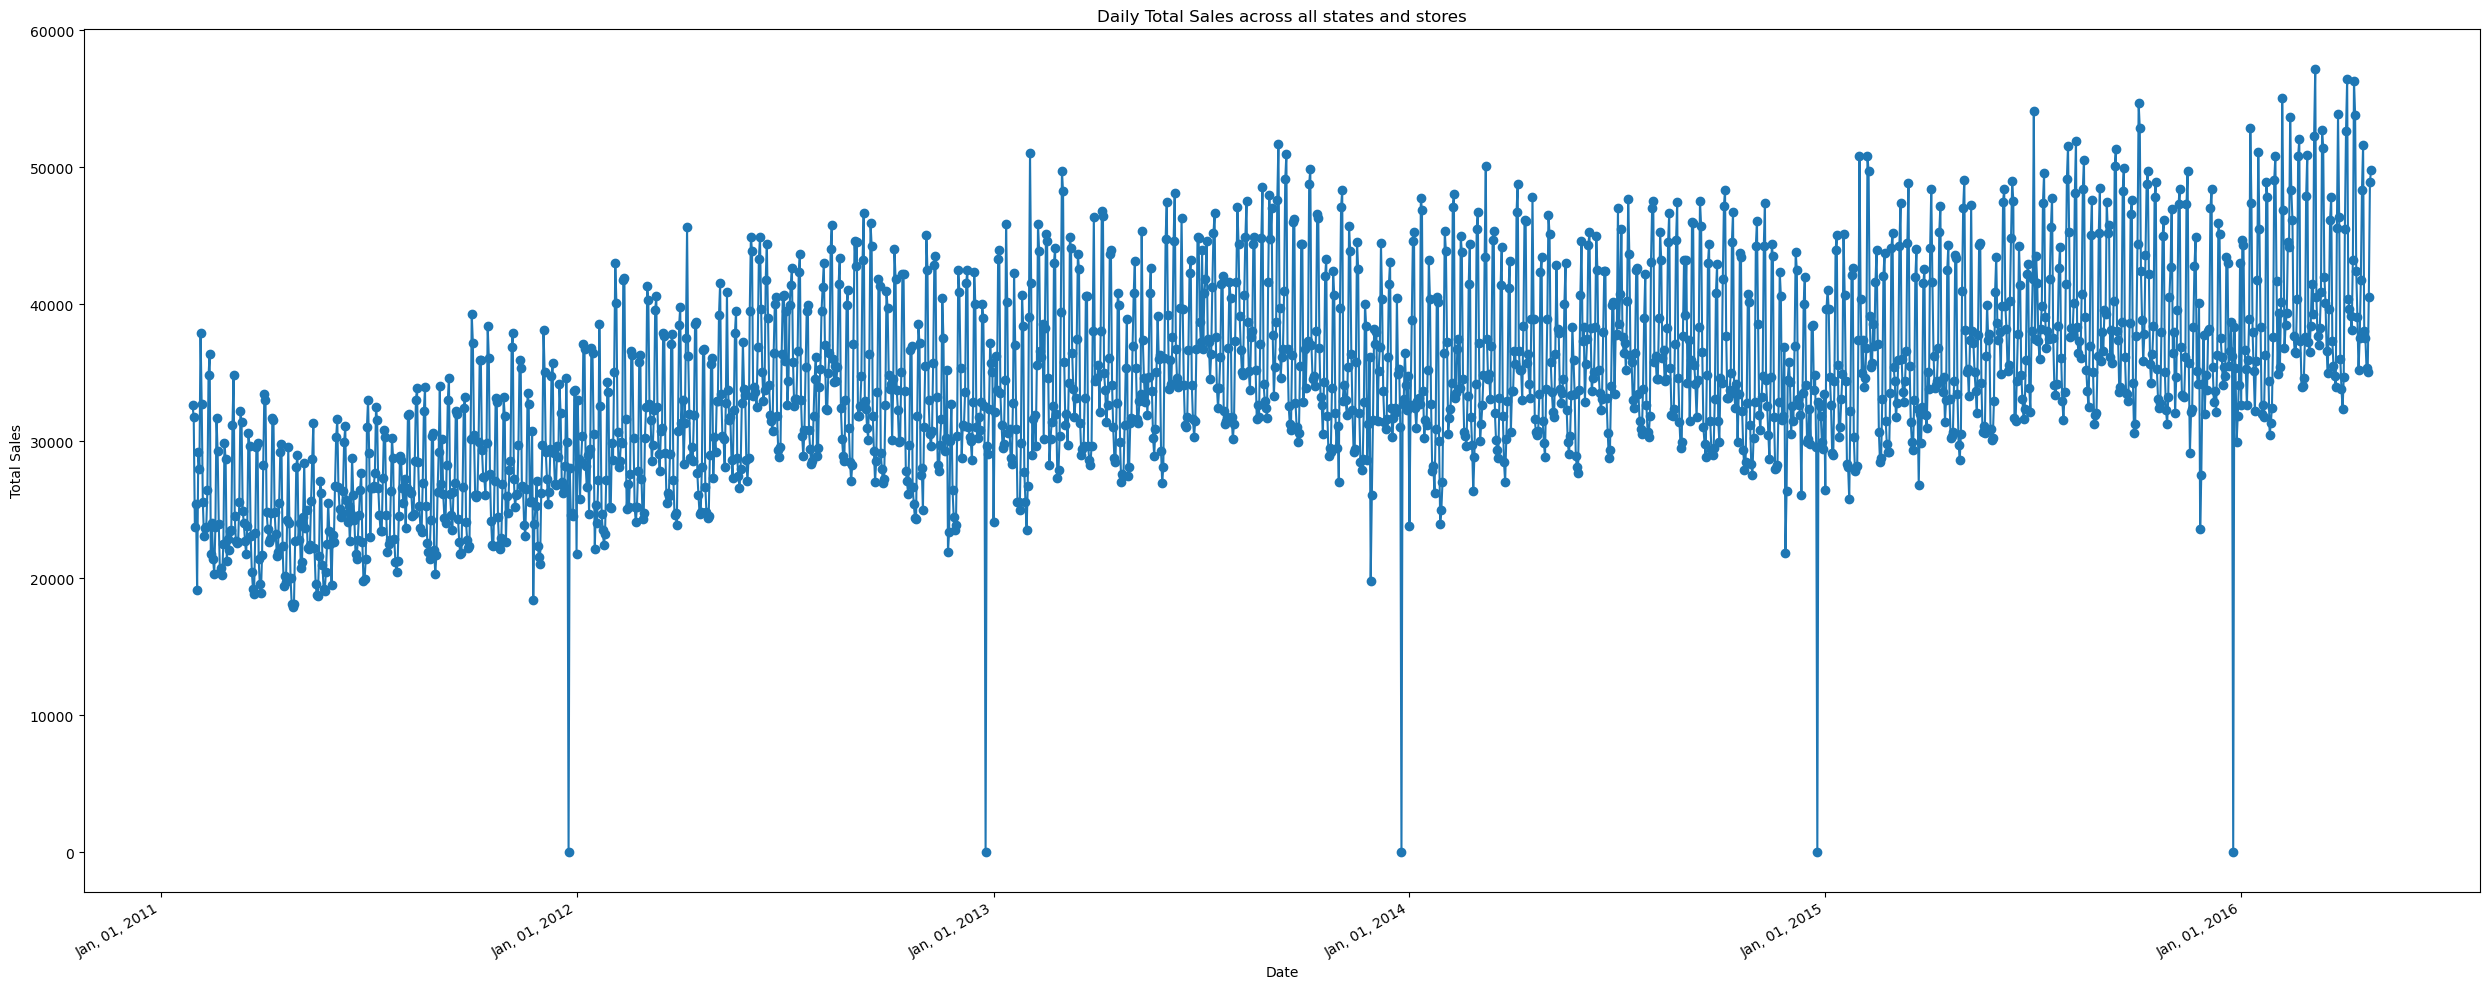

In [7]:

daily_overallsales = sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum'])
daily_overallsales = daily_overallsales.T.reset_index()
daily_overallsales.rename(columns={'sum':'Total_Sales','index':'d'}, inplace=True)
daily_overallsales = daily_overallsales.merge(calendar_df,on='d',how='left')
daily_overallsales = daily_overallsales[['date','Total_Sales']]
daily_overallsales['date'] = pd.to_datetime(daily_overallsales['date'])
daily_dates = daily_overallsales['date']
daily_totalSales = daily_overallsales['Total_Sales']

plt.plot_date(daily_dates,daily_totalSales,linestyle='solid')
plt.gcf().autofmt_xdate()
date_format = mat_dates.DateFormatter('%b, %d, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().set_size_inches(25, 10)
plt.title('Daily Total Sales across all states and stores')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

As we can see, we have some pattern around January 1 each year, which makes sense because stores don't seem to be open on that holiday and don't run sales.

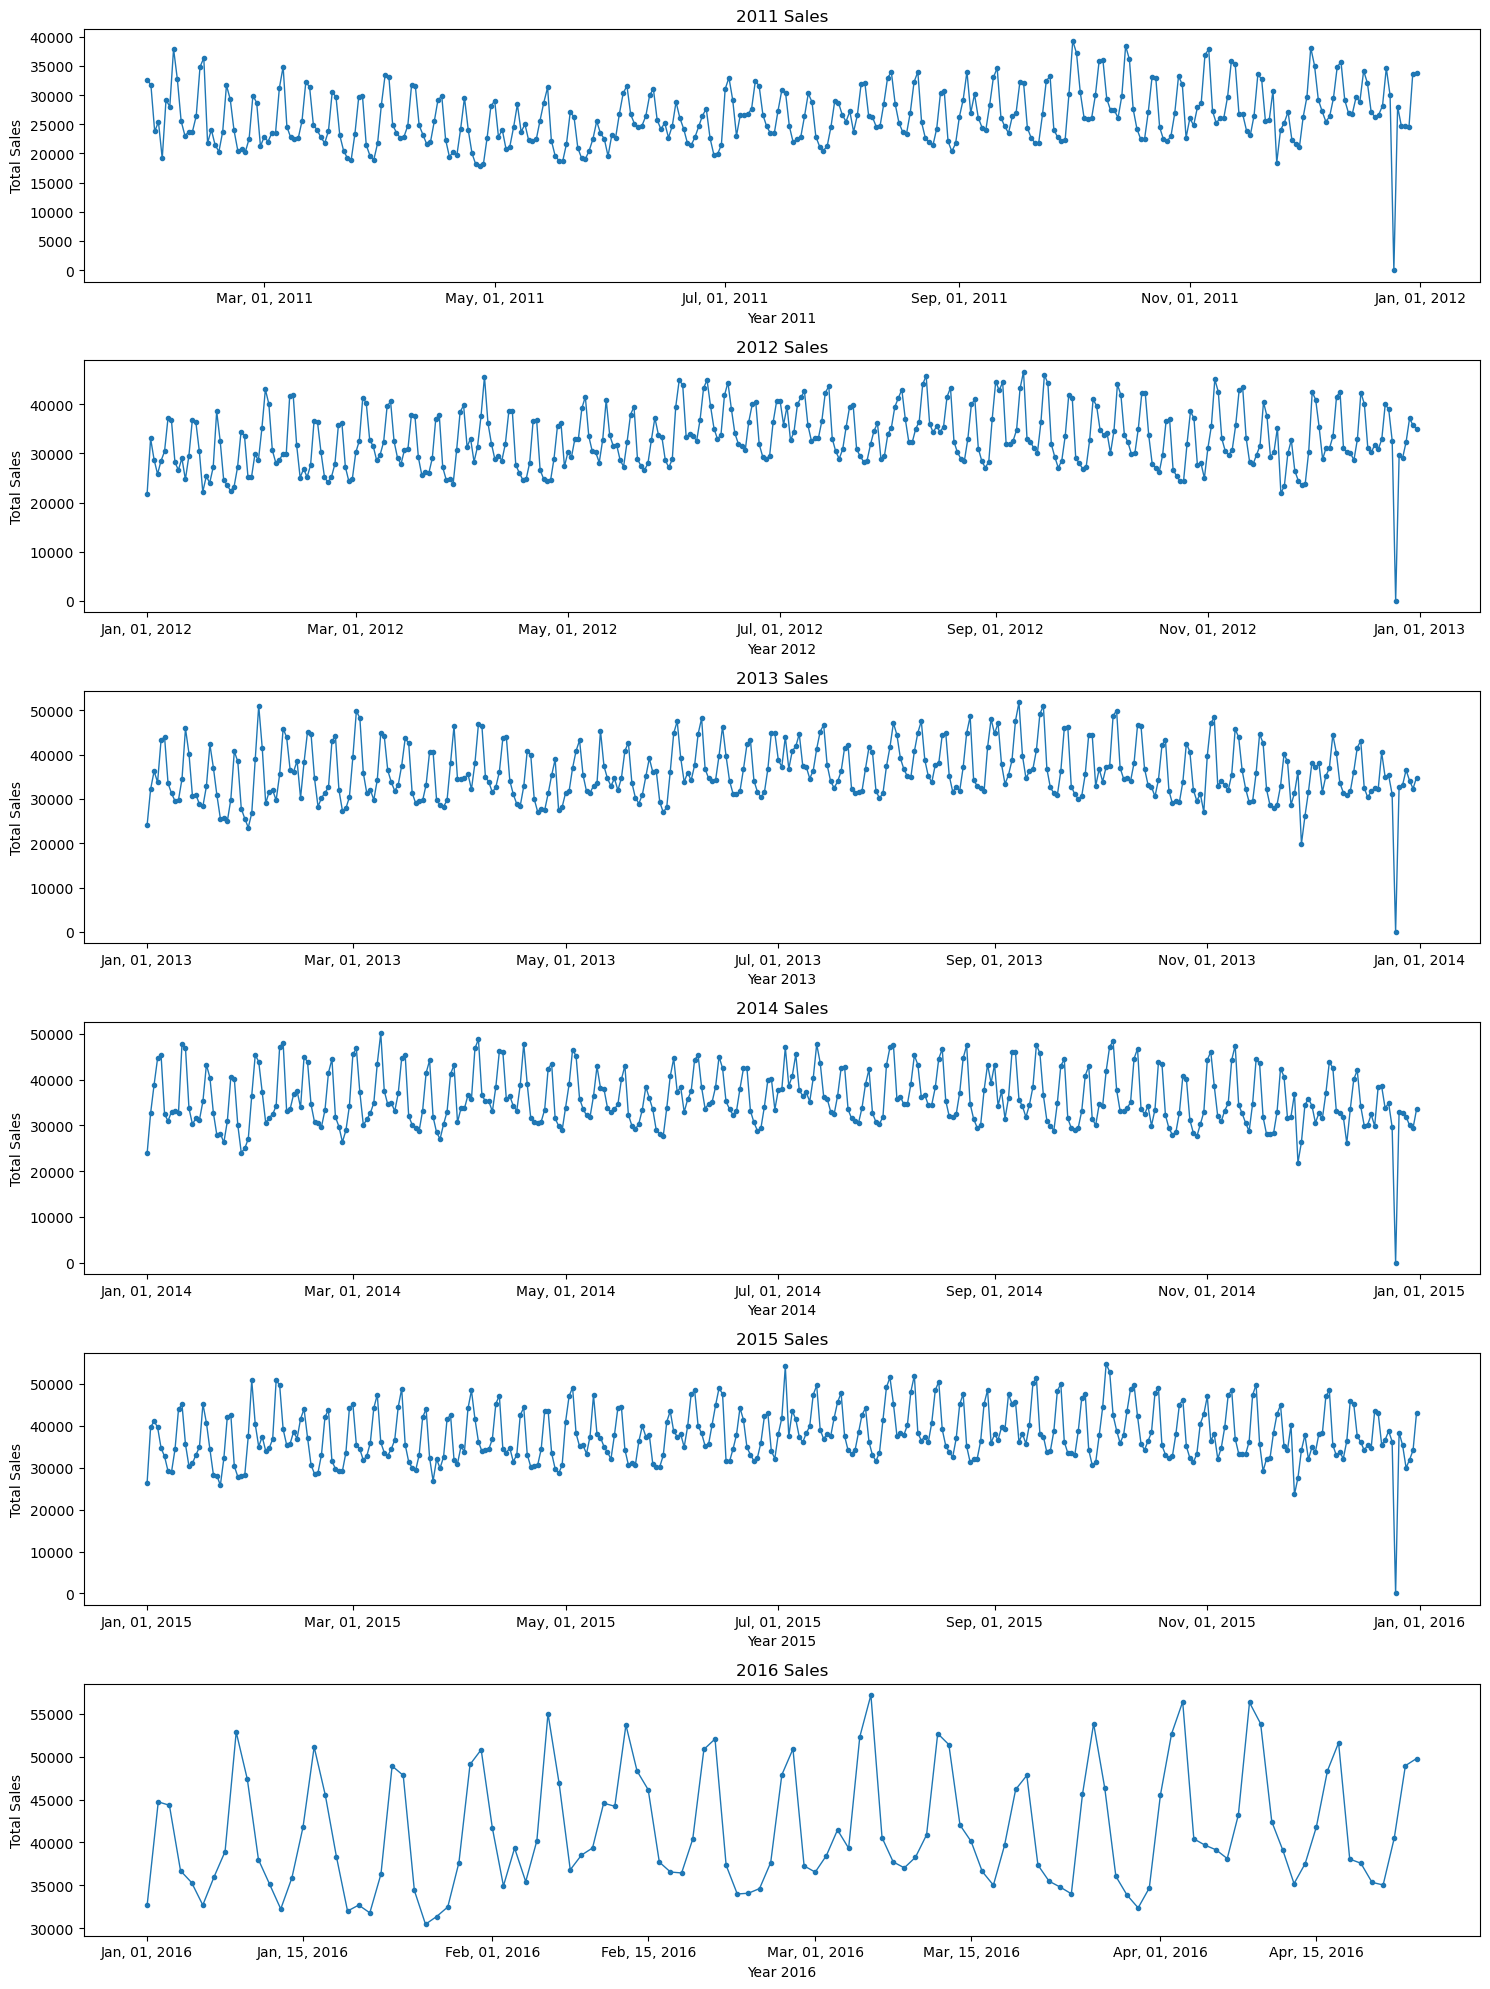

In [8]:

daily_overallsales['year'] = daily_overallsales['date'].dt.year
daily_overallsales_grp = daily_overallsales.groupby(['year'])
gf = daily_overallsales_grp.groups


gf_val_lst = list(gf.values())
date_format = mat_dates.DateFormatter('%b, %d, %Y')
fig = plt.figure(figsize=(15, 20))
for i in range(6):
    ax = fig.add_subplot(6,1,i+1)
    plt.plot_date(daily_overallsales.iloc[gf_val_lst[i]]['date'],daily_overallsales.iloc[gf_val_lst[i]]['Total_Sales'],linestyle='solid',linewidth=1,marker='.')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().set_title(str(2011+i)+ ' Sales')
    plt.gca().set_xlabel('Year '+str(2011+i))
    plt.gca().set_ylabel('Total Sales')
plt.tight_layout()
plt.show()

Between 2012 and 2015, we notice a consistent sales pattern repeating every two months, indicating annual seasonality. Additionally, the time-series data for each year from 2012 to 2015 exhibits stationary characteristics.

lets look at the global monthly seasonality sales

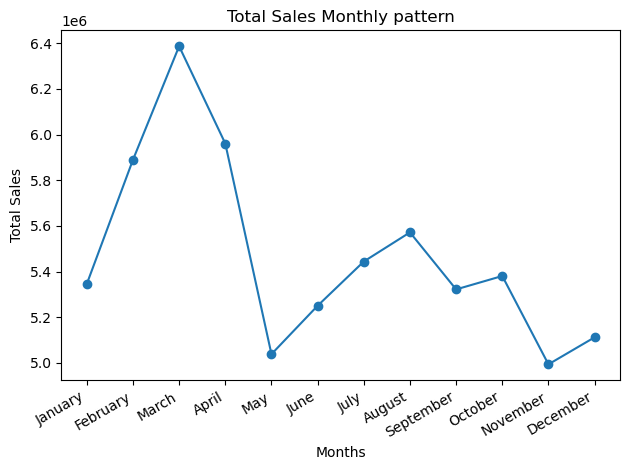

In [9]:

daily_overallsales['month']=daily_overallsales['date'].dt.month_name()
daily_overallsales_gpm = daily_overallsales.groupby('month').agg({'Total_Sales':'sum'}).reset_index()


months_order = list(daily_overallsales['date'].dt.month_name().unique())
daily_overallsales_gpm.index = pd.CategoricalIndex(daily_overallsales_gpm.month, categories=months_order, ordered=True)
daily_overallsales_gpm = daily_overallsales_gpm.sort_index()
daily_overallsales_gpm.reset_index(drop=True,inplace=True)


plt.plot_date(daily_overallsales_gpm['month'],daily_overallsales_gpm['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Monthly pattern')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

Sales peak in March and dip in November. There is a mid-year slump followed by a recovery, but another downturn occurs towards the end of the year.

Global weekly seasonality sales

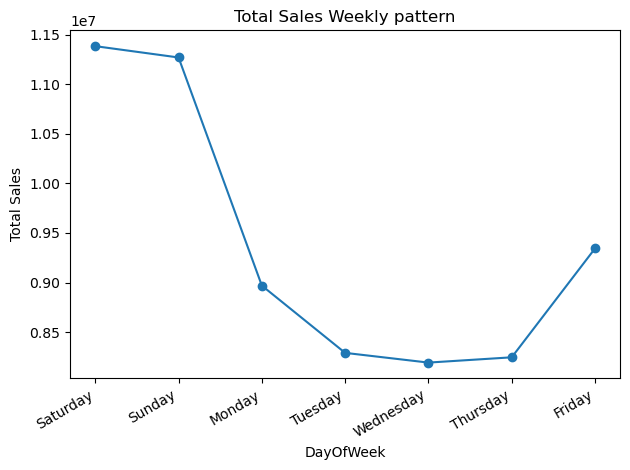

In [10]:

daily_overallsales['day_name']=daily_overallsales['date'].dt.day_name()
daily_overallsales_gpwd = daily_overallsales.groupby('day_name').agg({'Total_Sales':'sum'}).reset_index()


day_name_order = list(daily_overallsales['date'].dt.day_name().unique())
daily_overallsales_gpwd.index = pd.CategoricalIndex(daily_overallsales_gpwd.day_name, categories=day_name_order, ordered=True)
daily_overallsales_gpwd = daily_overallsales_gpwd.sort_index()
daily_overallsales_gpwd.reset_index(drop=True,inplace=True)

"""Plot of Dayofweek Vs Total Sales"""
plt.plot_date(daily_overallsales_gpwd['day_name'],daily_overallsales_gpwd['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Weekly pattern')
plt.xlabel('DayOfWeek')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()


Sales peak during weekends and gradually decrease throughout the weekdays, with a slight uptick on Fridays. There is a noticeable preference for shopping on weekends over weekdays, and generally, Saturday sees higher sales compared to Sunday.

Lets see on the sales proportion from each state

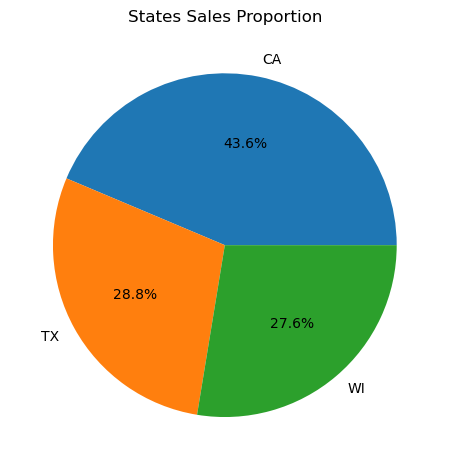

In [12]:

sales_st_grp = sales_df.groupby('state_id')
sales_st_grp_idx = list(sales_st_grp.groups.values())
CA_sales_df = sales_df.iloc[sales_st_grp_idx[0]]
CA_total_sales = int(CA_sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values)
TX_sales_df = sales_df.iloc[sales_st_grp_idx[1]]
TX_total_sales = int(TX_sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values)
WI_sales_df = sales_df.iloc[sales_st_grp_idx[2]]
WI_total_sales = int(WI_sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values)


states_overallSales = [CA_total_sales,TX_total_sales,WI_total_sales]
states = ['CA','TX','WI']
plt.pie(states_overallSales,labels=states,
        autopct = '%1.1f%%')
plt.title('States Sales Proportion')
plt.tight_layout()
plt.show()

California contributes the highest percentage to total sales, while the combined sales of Texas and Wisconsin are nearly equal.

Now lets see on the sales Proportion from each store

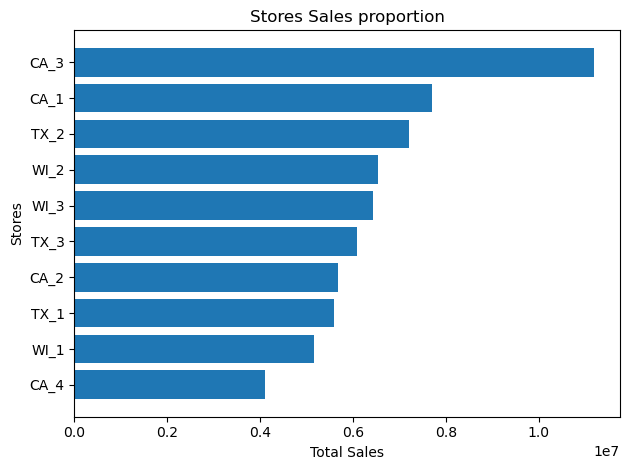

In [13]:

sales_store_grp = sales_df.groupby('store_id')
sales_store_grp_idx = list(sales_store_grp.groups.values())
stores_ky = list(sales_store_grp.groups.keys())
stores = []
store_sales = []
for i in range(len(stores_ky)):
    stores.append(stores_ky[i])
    store_df = sales_df.iloc[sales_store_grp_idx[i]]
    store_sales.append(int(store_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))


stores = list(np.asarray(stores)[np.argsort(np.asarray(store_sales))])
store_sales = list(np.asarray(store_sales)[np.argsort(np.asarray(store_sales))])
plt.barh(stores,store_sales)
plt.title('Stores Sales proportion')
plt.xlabel('Total Sales')
plt.ylabel('Stores')
plt.tight_layout()
plt.show()

Despite California accounting for 43.6% of total sales, it's notable that two of its stores rank among the bottom four in terms of total sales. Specifically, CA_3 store has the highest sales among them, while CA_4 store has the lowest sales

Here we get sales Proportion from each product category

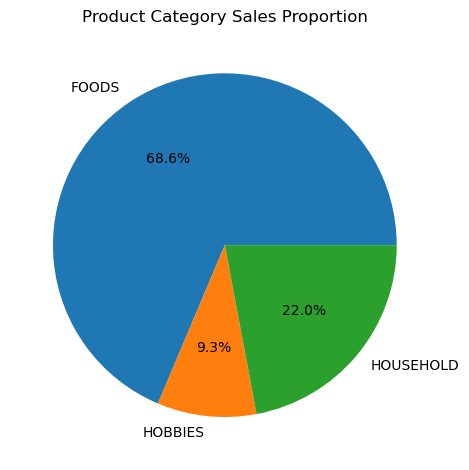

In [14]:

sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
prod_cats = []
prod_cats_sales = []
for i in range(len(cat_ky)):
    prod_cats.append(cat_ky[i])
    cat_df = sales_df.iloc[sales_cat_grp_idx[i]]
    prod_cats_sales.append(int(cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))


plt.pie(prod_cats_sales,labels=prod_cats,
        autopct = '%1.1f%%' )
plt.title('Product Category Sales Proportion')
plt.tight_layout()
plt.show()

The food category commands the largest share of sales, while hobbies exhibit the lowest. This suggests that people prioritize household necessities over leisure pursuits, with food being essential, thus driving higher sales.

Now let's get sales Proportion from each department

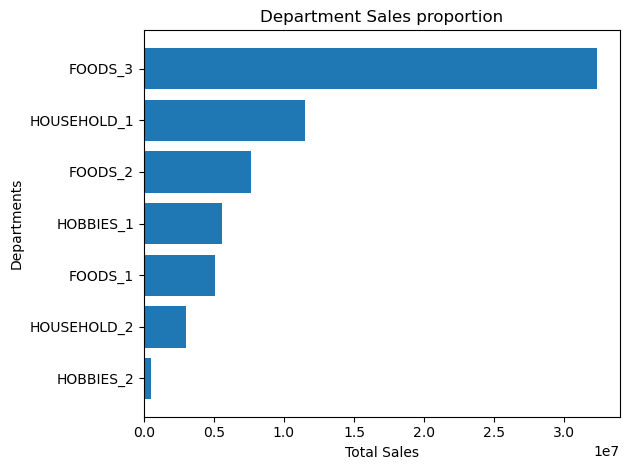

In [15]:

sales_dpt_grp = sales_df.groupby('dept_id')
sales_dpt_grp_idx = list(sales_dpt_grp.groups.values())
dept_ky = list(sales_dpt_grp.groups.keys())
depts = []
dept_sales = []
for i in range(len(dept_ky)):
    depts.append(dept_ky[i])
    dept_df = sales_df.iloc[sales_dpt_grp_idx[i]]
    dept_sales.append(int(dept_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))


depts = list(np.asarray(depts)[np.argsort(np.asarray(dept_sales))])
dept_sales = list(np.asarray(dept_sales)[np.argsort(np.asarray(dept_sales))])
plt.barh(depts,dept_sales)
plt.title('Department Sales proportion')
plt.xlabel('Total Sales')
plt.ylabel('Departments')
plt.tight_layout()
plt.show()

The 'FOODS_3' department leads in sales, while the 'HOBBIES_2' department has the lowest sales. Specifically, 'FOODS_3' alone accounts for 50% of total sales, with the remaining six departments collectively contributing the other half. Despite the 'HOBBIES' category comprising only 9.3% of total sales, its 'HOBBIES_1' department surprisingly records higher sales compared to the 'FOODS' category's 'FOODS_1' department.

Here we get sales proportion of each product category for each state

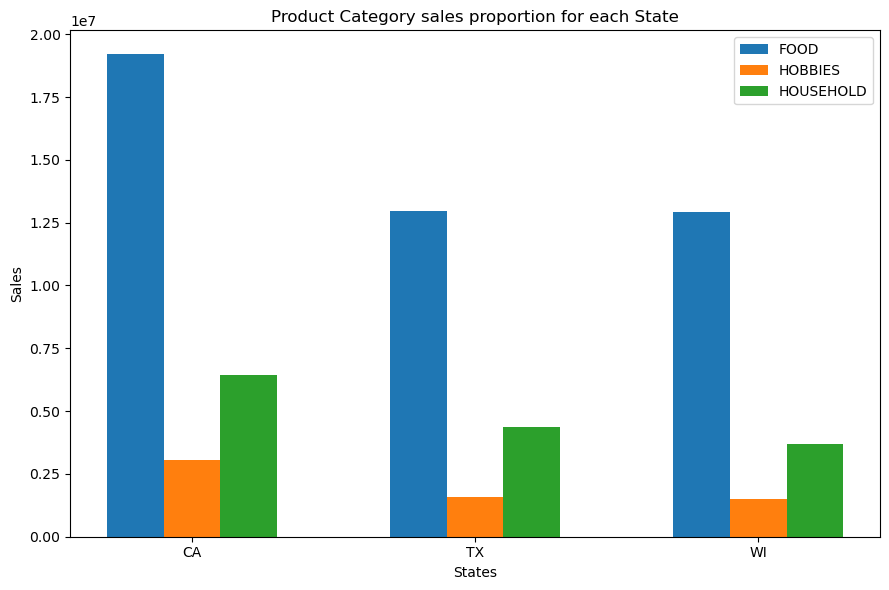

In [16]:

sales_state_cat_grp = sales_df.groupby(['state_id','cat_id'])
sales_state_cat_grp_idx = list(sales_state_cat_grp.groups.values())
state_cat_ky = list(sales_state_cat_grp.groups.keys())
states = []
food_cat_sales = []
hobbies_cat_sales = []
household_cat_sales = []
for i in range(len(state_cat_ky)):
    if state_cat_ky[i][0] not in states:
        states.append(state_cat_ky[i][0])
    state_cat_df = sales_df.iloc[sales_state_cat_grp_idx[i]]
    if i%3 == 0:
        food_cat_sales.append(int(state_cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))
    elif i%3 == 1:
        hobbies_cat_sales.append(int(state_cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))
    else:
        household_cat_sales.append(int(state_cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))



x_idx = np.arange(len(states))
width = 0.2
plt.figure(figsize=(9,6))
plt.bar(x_idx - width, food_cat_sales,  width = width, label="FOOD")
plt.bar(x_idx, hobbies_cat_sales, width = width, label="HOBBIES")
plt.bar(x_idx + width, household_cat_sales,  width = width,  label="HOUSEHOLD")

plt.legend()
plt.xticks(ticks=x_idx, labels=states)
plt.title("Product Category sales proportion for each State")
plt.xlabel("States")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

All three states show a similar proportion of sales across the three product categories. Specifically, the sales proportion for the food category is identical between Texas and Wisconsin.

Sales proportion of each satate for each product category

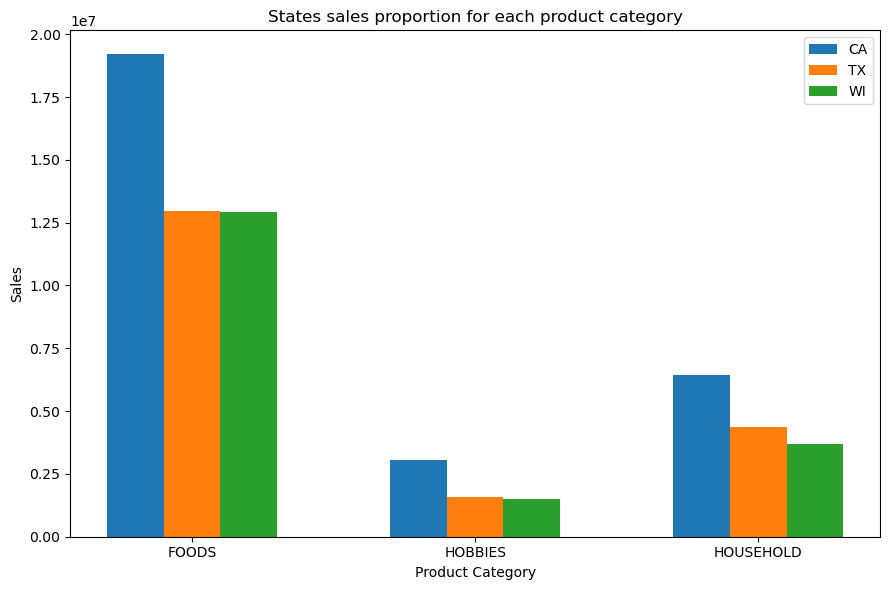

In [17]:

sales_cat_state_grp = sales_df.groupby(['cat_id','state_id'])
sales_cat_state_grp_idx = list(sales_cat_state_grp.groups.values())
cat_state_ky = list(sales_cat_state_grp.groups.keys())
cats = []
ca_sales = []
tx_sales = []
wi_sales = []
for i in range(len(cat_state_ky)):
    if cat_state_ky[i][0] not in cats:
        cats.append(cat_state_ky[i][0])
    cat_state_df = sales_df.iloc[sales_cat_state_grp_idx[i]]
    if i%3 == 0:
        ca_sales.append(int(cat_state_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))
    elif i%3 == 1:
        tx_sales.append(int(cat_state_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))
    else:
        wi_sales.append(int(cat_state_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))


x_idx = np.arange(len(cats))
width = 0.2
plt.figure(figsize=(9,6))
plt.bar(x_idx - width, ca_sales,  width = width, label="CA")
plt.bar(x_idx, tx_sales, width = width,  label="TX")
plt.bar(x_idx + width, wi_sales,  width = width,  label="WI")

plt.legend()
plt.xticks(ticks=x_idx, labels=cats)
plt.title("States sales proportion for each product category")
plt.xlabel("Product Category")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

The food category consistently leads in sales across all three states, while hobbies consistently show the lowest sales. Interestingly, Texas and Wisconsin have similar proportions of sales for the hobbies product category.

#### SNAP analysis ####

Aggregate by cat_id to determine the sales proportion of each product category concerning SNAP versus Non-SNAP days.

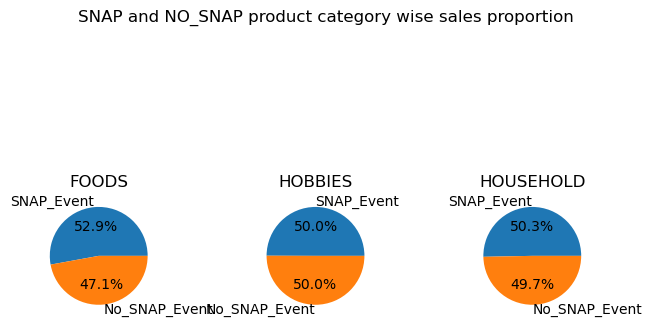

In [18]:

snap_cat_sales = {}
for i in range(len(cat_ky)):
    sales_cat_grp_df = sales_df.iloc[sales_cat_grp_idx[i]].loc[:,'d_1':'d_1913']
    sales_cat_grp_df = pd.melt(sales_cat_grp_df,var_name='d',value_name='sales')
    sales_cat_grp_df = sales_cat_grp_df.merge(calendar_df,on='d',how='left')
    snap_cat_sales[cat_ky[i]] = {}
    snap_cat_sales[cat_ky[i]]['Total_Sales'] = int(sales_cat_grp_df[['sales']].sum().values)
    snap_cat_sales[cat_ky[i]]['SNAP_Sales'] = int(sales_cat_grp_df[(sales_cat_grp_df['snap_CA'] == 1) |(sales_cat_grp_df['snap_TX'] == 1)|(sales_cat_grp_df['snap_WI'] == 1)]['sales'].sum())


labels = ['SNAP_Event', 'No_SNAP_Event']
snap_cat_sales_ky = list(snap_cat_sales.keys())
FOODS_sales = [snap_cat_sales['FOODS']['SNAP_Sales'], snap_cat_sales['FOODS']['Total_Sales'] - snap_cat_sales['FOODS']['SNAP_Sales']]
HOBBIES_sales = [snap_cat_sales['HOBBIES']['SNAP_Sales'], snap_cat_sales['HOBBIES']['Total_Sales'] - snap_cat_sales['HOBBIES']['SNAP_Sales']]
HOUSEHOLD_sales = [snap_cat_sales['HOUSEHOLD']['SNAP_Sales'], snap_cat_sales['HOUSEHOLD']['Total_Sales'] - snap_cat_sales['HOUSEHOLD']['SNAP_Sales']]

fig, (ax1,ax2,ax3) = plt.subplots(1, 3)

fig.suptitle('SNAP and NO_SNAP product category wise sales proportion')

ax1.pie(FOODS_sales,labels = labels, 
        autopct = '%1.1f%%')
ax1.set_title(snap_cat_sales_ky[0])

ax2.pie(HOBBIES_sales,labels = labels, 
        autopct = '%1.1f%%')
ax2.set_title(snap_cat_sales_ky[1])

ax3.pie(HOUSEHOLD_sales,labels = labels, 
        autopct = '%1.1f%%')
ax3.set_title(snap_cat_sales_ky[2])

plt.tight_layout()
plt.show()

In [18]:
snap_cat_sales

{'FOODS': {'Total_Sales': 45089939, 'SNAP_Sales': 23838159},
 'HOBBIES': {'Total_Sales': 6124800, 'SNAP_Sales': 3059566},
 'HOUSEHOLD': {'Total_Sales': 14480670, 'SNAP_Sales': 7285350}}

In [20]:
# Calculate elasticity for each category
elasticities = {}

for category, sales_data in snap_cat_sales.items():
    total_sales = sales_data['Total_Sales']
    snap_sales = sales_data['SNAP_Sales']
    
    # Calculate percentage changes
    delta_total_sales = snap_sales - total_sales
    
    if snap_sales != 0:
        percent_change_snap_sales = delta_total_sales / snap_sales
    else:
        percent_change_snap_sales = 0  # or handle as needed
    
    if total_sales != 0:
        percent_change_total_sales = delta_total_sales / total_sales
    else:
        percent_change_total_sales = 0  # or handle as needed
    
    # Calculate elasticity, handle division by zero
    if percent_change_snap_sales != 0:
        elasticity = percent_change_total_sales / percent_change_snap_sales
    else:
        elasticity = float('inf')  # or handle as needed
    
    # Store elasticity result
    elasticities[category] = elasticity

# Print results
for category, elasticity in elasticities.items():
    print(f"Elasticity of demand for {category}: {elasticity:.2f}")

Elasticity of demand for FOODS: 0.53
Elasticity of demand for HOBBIES: 0.50
Elasticity of demand for HOUSEHOLD: 0.50


Sales from SNAP days outperform sales from non-SNAP days specifically within the FOOD product category. Conversely, Hobbies and Household product categories show similar sales numbers between SNAP and non-SNAP days.

Group by state_id for the sales proportion of each state wrt SNAP Vs Non-SNAP days

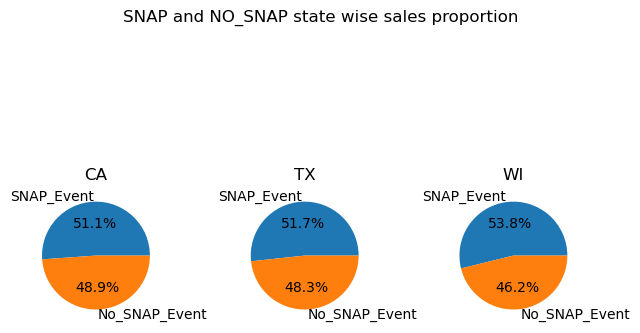

In [19]:

state_ky = list(sales_st_grp.groups.keys())
snap_state_sales = {}
for i in range(len(state_ky)):
    sales_state_grp_df = sales_df.iloc[sales_st_grp_idx[i]].loc[:,'d_1':'d_1913']
    sales_state_grp_df = pd.melt(sales_state_grp_df,var_name='d',value_name='sales')
    sales_state_grp_df = sales_state_grp_df.merge(calendar_df,on='d',how='left')
    snap_state_sales[state_ky[i]] = {}
    snap_state_sales[state_ky[i]]['Total_Sales'] = int(sales_state_grp_df[['sales']].sum().values)
    snap_state_sales[state_ky[i]]['SNAP_Sales'] = int(sales_state_grp_df[(sales_state_grp_df['snap_CA'] == 1) |(sales_state_grp_df['snap_TX'] == 1)|(sales_state_grp_df['snap_WI'] == 1)]['sales'].sum())


labels = ['SNAP_Event', 'No_SNAP_Event']
snap_state_sales_ky = list(snap_state_sales.keys())
CA_sales = [snap_state_sales['CA']['SNAP_Sales'], snap_state_sales['CA']['Total_Sales'] - snap_state_sales['CA']['SNAP_Sales']]
TX_sales = [snap_state_sales['TX']['SNAP_Sales'], snap_state_sales['TX']['Total_Sales'] - snap_state_sales['TX']['SNAP_Sales']]
WI_sales = [snap_state_sales['WI']['SNAP_Sales'], snap_state_sales['WI']['Total_Sales'] - snap_state_sales['WI']['SNAP_Sales']]

fig, (ax1,ax2,ax3) = plt.subplots(1, 3)

fig.suptitle('SNAP and NO_SNAP state wise sales proportion')

ax1.pie(CA_sales,labels = labels, 
        autopct = '%1.1f%%')
ax1.set_title(snap_state_sales_ky[0])

ax2.pie(TX_sales,labels = labels,
        autopct = '%1.1f%%')
ax2.set_title(snap_state_sales_ky[1])

ax3.pie(WI_sales,labels = labels, 
        autopct = '%1.1f%%')
ax3.set_title(snap_state_sales_ky[2])

plt.tight_layout()
plt.show()

SNAP sales are higher in Wisconsin compared to California, where they are lower. Specifically, SNAP sales in Wisconsin significantly exceed non-SNAP sales.

Now let's get number of days with and without events and plot the distribution

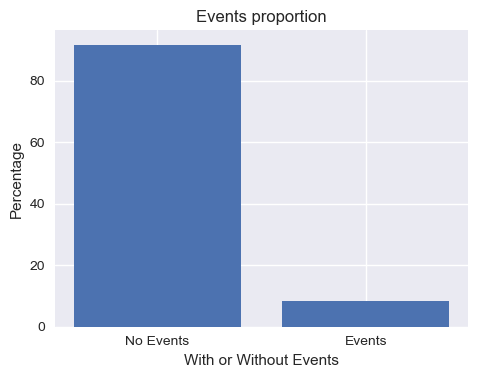

In [22]:

df = calendar_df[['event_name_1']]
no_event_per = ((len(df) - int(df.count()))/len(df))*100
event_per = (int(df.count())/len(df))*100
event_lst = [('No Events',no_event_per),('Events',event_per)]
events = [x[0] for x in event_lst]
events_count = [x[1] for x in event_lst]

plt.figure(figsize=(5,4))
plt.bar(events,events_count)
plt.title('Events proportion')
plt.xlabel('With or Without Events')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

The majority of days, over 90%, are non-event days, while only about 10% of days are categorized as event days.

We will get number of events of each even_type and plot the distribution

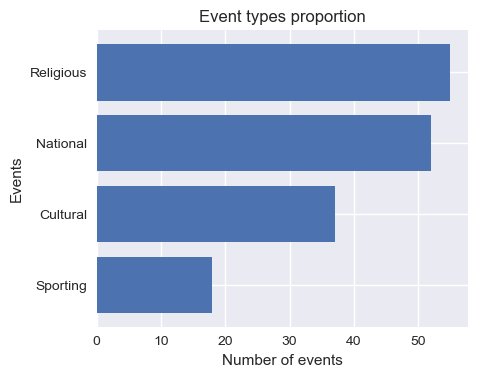

In [23]:

event_lst = [tuple(x) for x in calendar_df[['event_type_1']].value_counts().reset_index().values]
events = [x[0] for x in event_lst]
events.reverse()
events_count = [x[1] for x in event_lst]
events_count.reverse()
plt.figure(figsize=(5,4))
plt.barh(events,events_count)
plt.title('Event types proportion')
plt.xlabel('Number of events')
plt.ylabel('Events')
plt.tight_layout()
plt.show()

There are more religious events than sporting events. National and religious events occur about equally often

Now let's get number of items of each item_category and plot the distribution

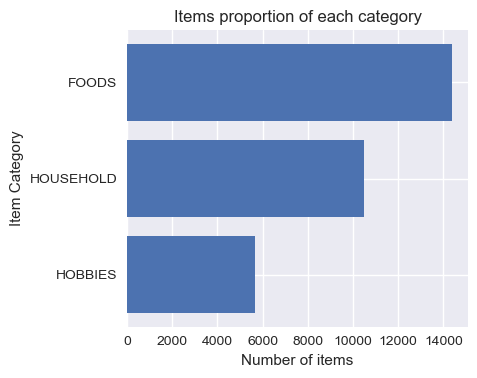

In [24]:

cat_item_ct = [tuple(x) for x in sales_df['cat_id'].value_counts().reset_index().values]
catgs = [x[0] for x in cat_item_ct]
catgs.reverse()
cat_item_count = [x[1] for x in cat_item_ct]
cat_item_count.reverse()
plt.figure(figsize=(5,4))
plt.barh(catgs,cat_item_count)
plt.title('Items proportion of each category')
plt.xlabel('Number of items')
plt.ylabel('Item Category')
plt.tight_layout()
plt.show()

There are more items in the Food category and fewer in the Hobbies category. This could be one reason why sales are higher in the Food category and lower in the Hobbies category.

Sales proportion of each product category for each year

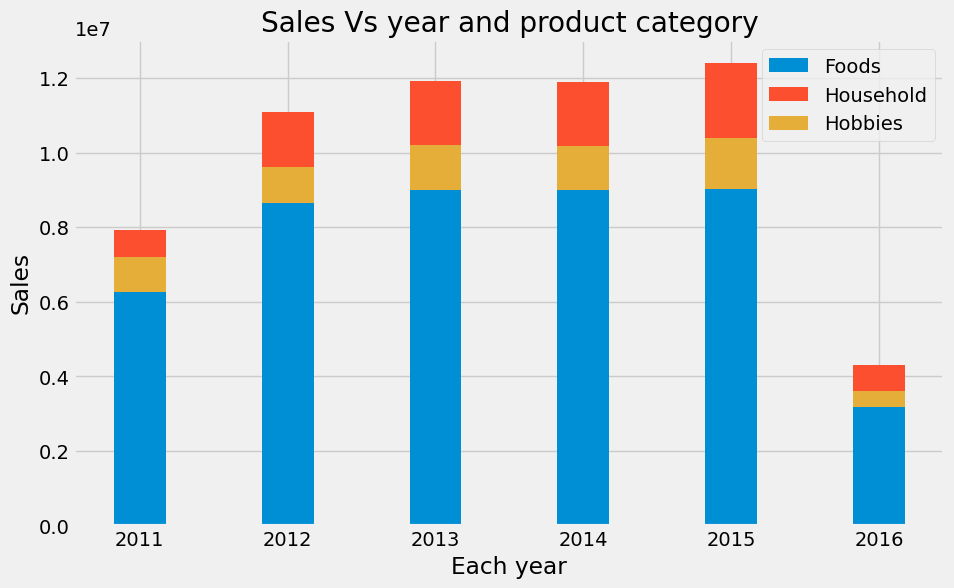

In [24]:

sales_cat = {}
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
for i in range(len(cat_ky)):
    sales_cat_df = pd.melt(sales_df.iloc[sales_cat_grp_idx[i]].loc[:,'d_1':'d_1913'],var_name='d',value_name='sales').merge(calendar_df,on='d',how='left')
    sales_cat_yr_grp = sales_cat_df.groupby('year').groups
    sales_cat_yr_idx = list(sales_cat_yr_grp.values())
    sales_cat_yr_ky = list(sales_cat_yr_grp.keys())
    sales_cat[cat_ky[i]] = {}
    for j in range(len(sales_cat_yr_ky)):
        sales_cat[cat_ky[i]][sales_cat_yr_ky[j]] = sales_cat_df.iloc[sales_cat_yr_idx[j]]['sales'].sum()


N = 6
FOODS_sales = list(sales_cat['FOODS'].values())
HOBBIES_sales = list(sales_cat['HOBBIES'].values())
HOUSEHOLD_sales = list(sales_cat['HOUSEHOLD'].values())

ind = np.arange(N)
width = 0.35

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
p1 = plt.bar(ind, FOODS_sales, width)
p2 = plt.bar(ind, HOUSEHOLD_sales, width,bottom=FOODS_sales)
p3 = plt.bar(ind, HOBBIES_sales, width,bottom=FOODS_sales)

plt.xlabel('Each year')
plt.ylabel('Sales')
plt.title('Sales Vs year and product category')
plt.xticks(ind, (2011, 2012, 2013, 2014, 2015, 2016))
plt.legend((p1[0], p2[0], p3[0]), ('Foods', 'Household','Hobbies'))

plt.show()

In 2015, sales were highest, while they were lowest in 2016 (based on only 4 months of data). Across the years, the Food category consistently had higher sales compared to Household and Hobbies categories. Food, Household, and Hobbies had similar sales in 2013 and 2014. Sales in the Food category didn't vary much from 2012 to 2015.

Here, we obtain daily sales data for each product category and create individual plots showing the daily sales for each category

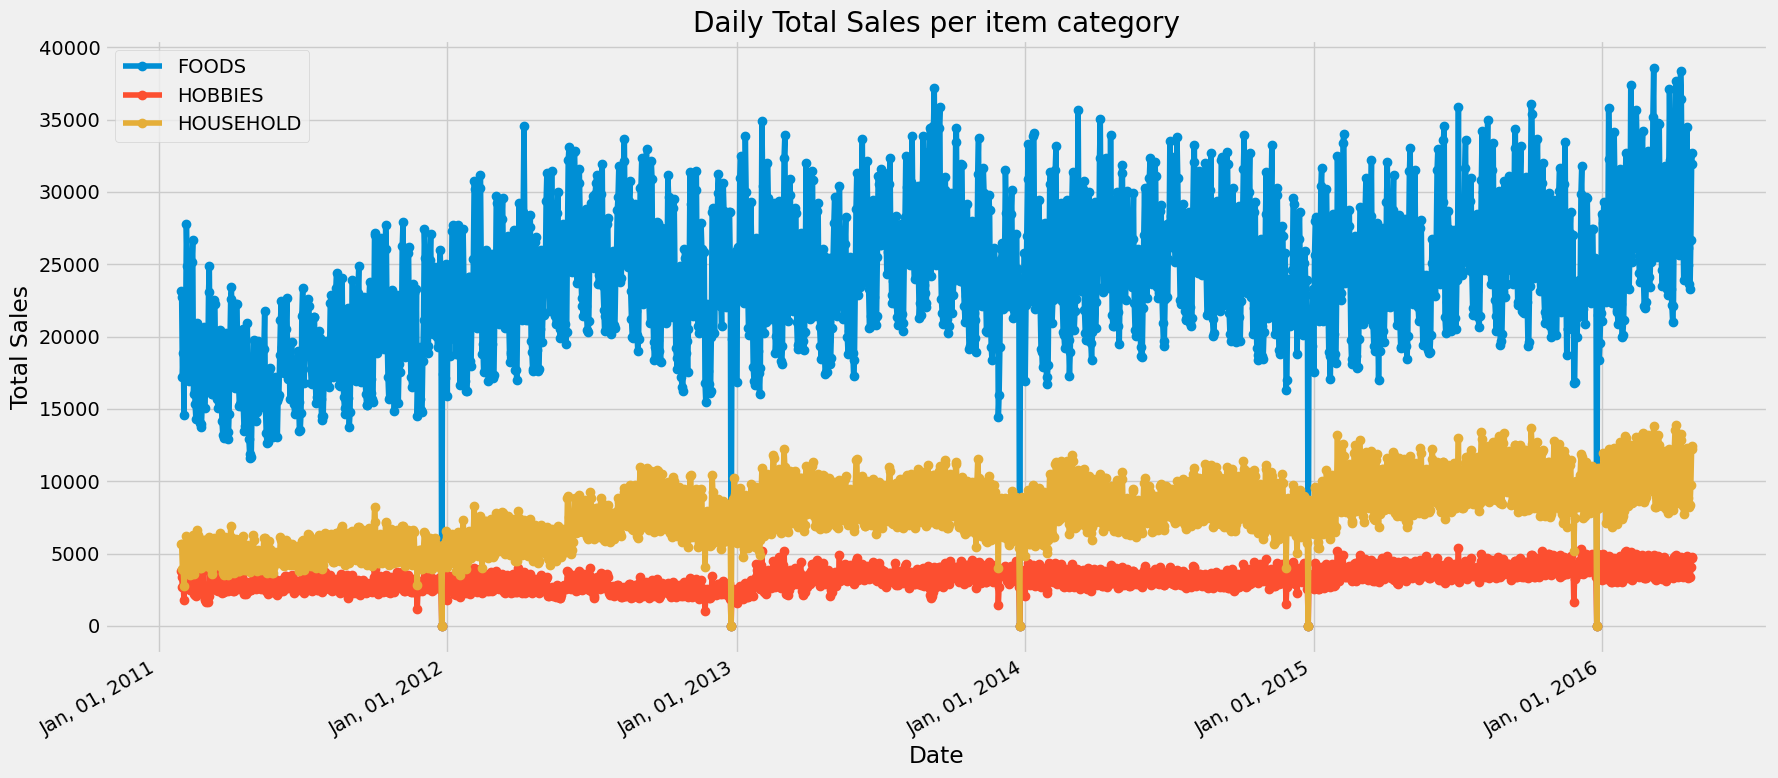

In [21]:

for i in range(len(cat_ky)):
    df = sales_df.iloc[sales_cat_grp_idx[i]].loc[:,'d_1':'d_1913'].aggregate(['sum']).T.reset_index()
    df.rename(columns={'sum':'Total_Sales','index':'d'}, inplace=True)
    df = df.merge(calendar_df,on='d',how='left')
    df = df[['date','Total_Sales']]
    df['date'] = pd.to_datetime(df['date'])
    item_dates = df['date']
    item_totalSales = df['Total_Sales']
    plt.plot_date(item_dates,item_totalSales,linestyle='solid',label=cat_ky[i])
    plt.gcf().autofmt_xdate()
    date_format = mat_dates.DateFormatter('%b, %d, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().set_size_inches(18, 8)
plt.title('Daily Total Sales per item category')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

The Food category has the highest daily total sales, with a rising trend over the years. Hobbies category sales are the lowest and remain relatively constant over time. Household category sales also show an upward trend over the years

Let's  chose sample of products and observing their daily sales pattern

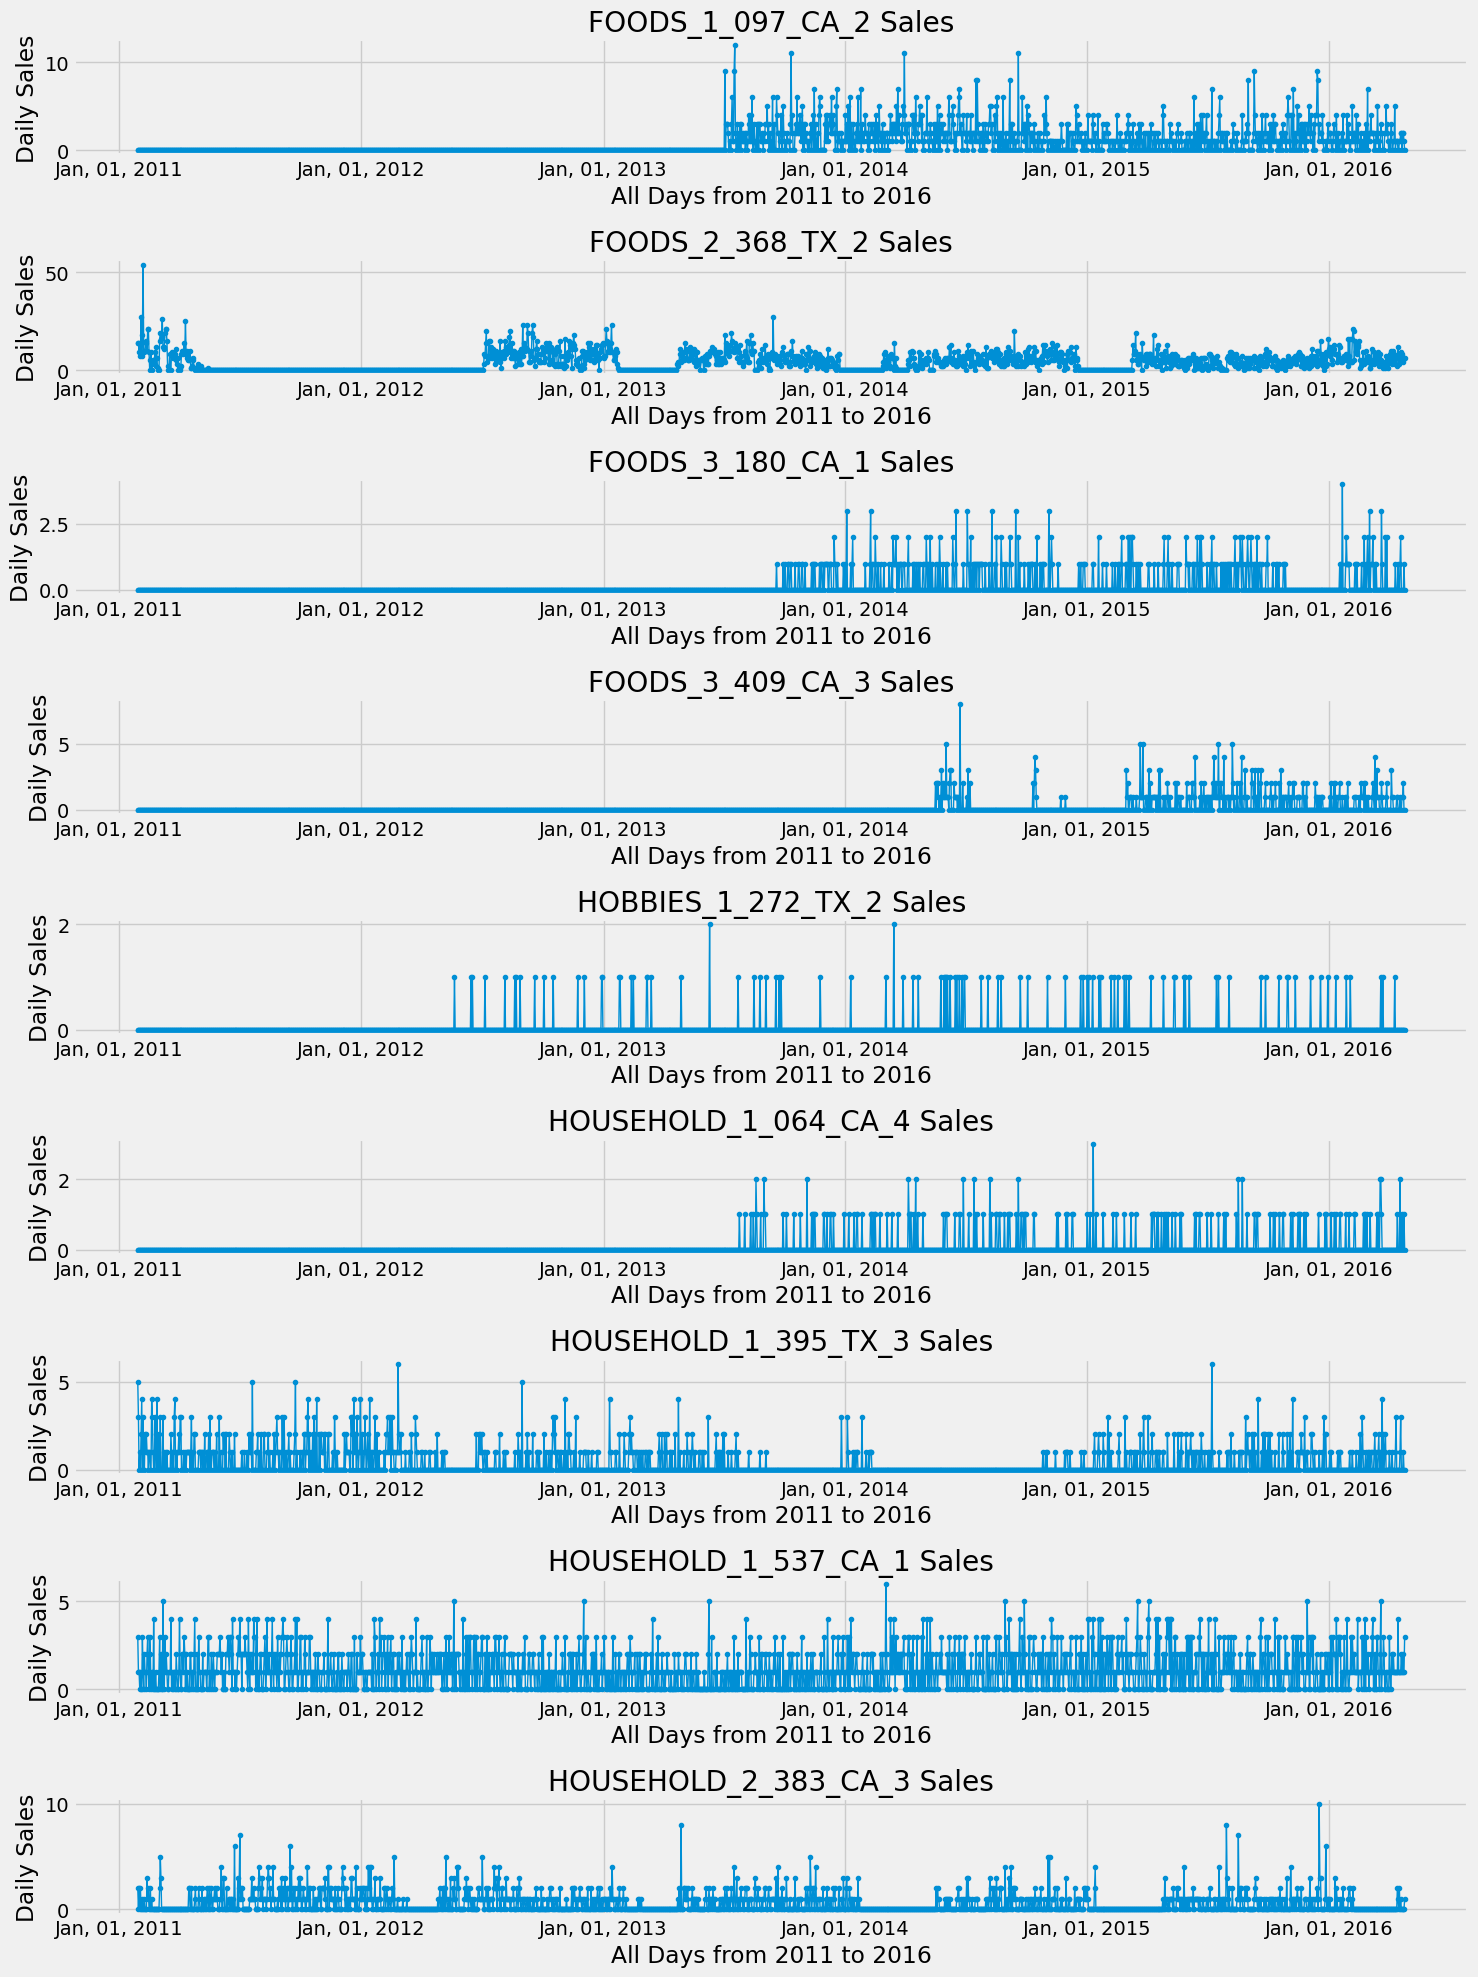

In [22]:

np.random.seed(42)

sample_sales_df = sales_df.reindex(np.random.permutation(sales_df.index)).iloc[:9]
keep_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
sample_sales_df = pd.melt(sample_sales_df,id_vars=keep_cols,var_name='d',value_name = 'sales')
sample_sales_df = sample_sales_df.merge(calendar_df,on='d',how='left')
sample_sales_df_grp = sample_sales_df.groupby('id')
sample_sales_df_idx = list(sample_sales_df_grp.groups.values())
id_ky = list(sample_sales_df_grp.groups.keys())
id_ky = [x.replace('_validation','') for x in id_ky]

df = sample_sales_df.iloc[sample_sales_df_idx[0]]
df['date'] = pd.to_datetime(df['date'])
s_dates = df['date']
date_format = mat_dates.DateFormatter('%b, %d, %Y')
N = len(id_ky)



"""Daily sales pattern of sample of products"""
fig = plt.figure(figsize=(15, 20))
for i in range(N):
    ax = fig.add_subplot(N,1,i+1)
    df1 = sample_sales_df.iloc[sample_sales_df_idx[i]]
    plt.plot_date(s_dates,df1['sales'],linestyle='solid',linewidth=1,marker='.')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().set_title(id_ky[i]+ ' Sales')
    plt.gca().set_xlabel('All Days from 2011 to 2016')
    plt.gca().set_ylabel('Daily Sales')
plt.tight_layout()
plt.show()

Looking at the sales patterns of sample items from various stores, we notice an irregular sales pattern with no steady trend. Sales occasionally drop to zero at unpredictable intervals. For instance, sales of Food items can be notably high, sometimes exceeding 30 in a single day (e.g., FOODS_2_152_TX_2). On the other hand, sales of certain items, such as HOBBIES_1_214_CA_2, can be very low, sometimes less than 3 units per day.

 price of items for each store

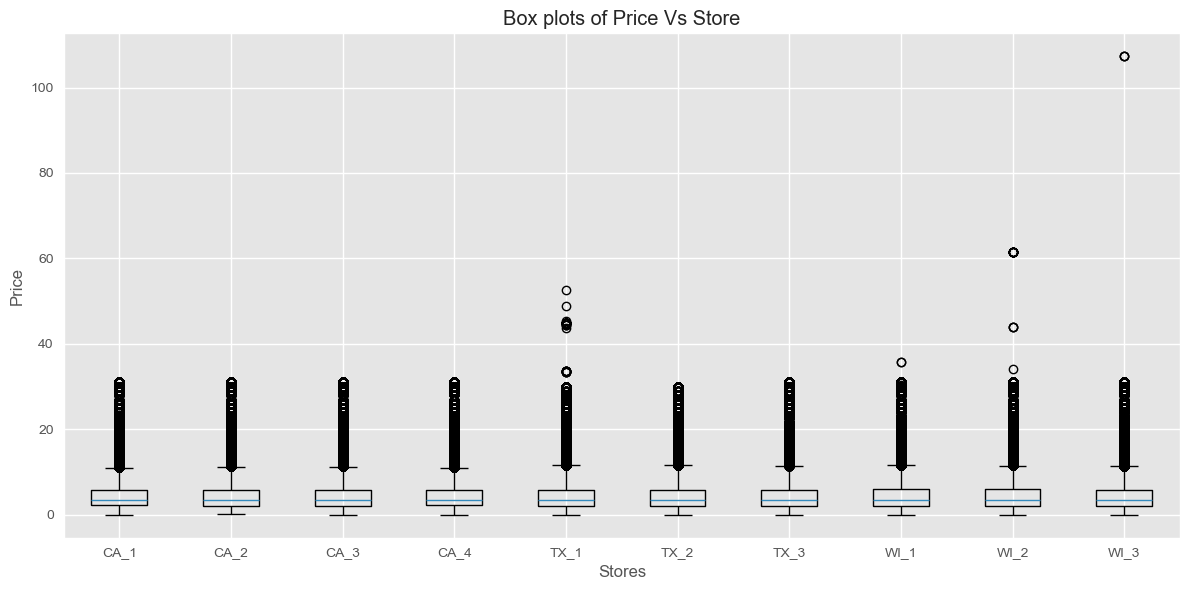

In [28]:

price_grp = prices_df.groupby('store_id')
price_lst_idx = list(price_grp.groups.values())
price_str_ky = list(price_grp.groups.keys())

price_bx = []
for i in range(len(price_str_ky)):
    price_bx.append(prices_df.iloc[price_lst_idx[i]]['sell_price'].values)
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.boxplot ([x for x in price_bx],labels=price_str_ky)
plt.title('Box plots of Price Vs Store')
plt.xlabel('Stores')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

The price distribution across all stores is similar, with median prices overlapping. The 50th percentile price across stores is below  2.5 USD, and the 75th percentile is below  5 USD. Many stores have outlier prices, particularly in WI_3 where some prices exceed  100 USD.

<h3>Missing Value Analysis</h3>

<h4>Calender data</h4>

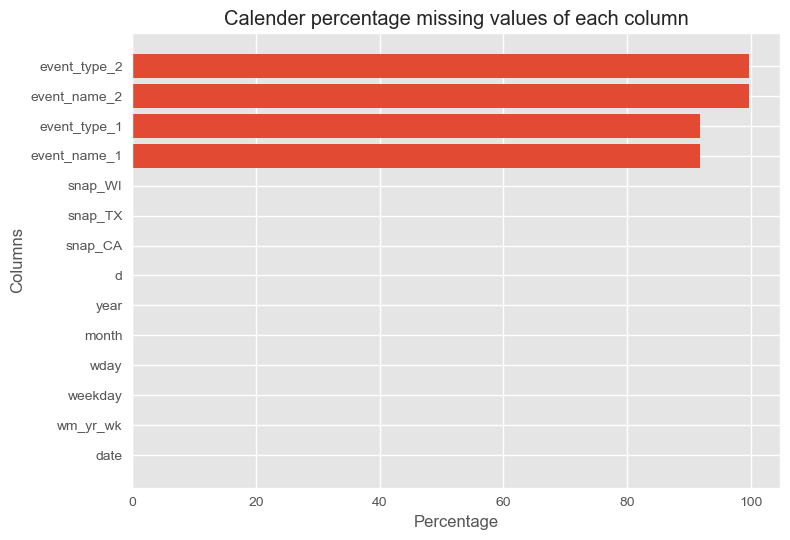

In [29]:
calendar_series = (calendar_df.isnull().sum()/len(calendar_df))*100
percent_miss_val = np.asarray(calendar_series.values)[np.argsort(np.asarray(calendar_series.values))]
calendar_cols = np.asarray(calendar_series.index)[np.argsort(np.asarray(calendar_series.values))]
plt.barh(calendar_cols,percent_miss_val)
plt.title('Calender percentage missing values of each column')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()

<h3>Sales data</h3>

In [30]:
sales_series = (sales_df.loc[:,'id':'state_id'].isnull().sum()/len(sales_df))*100
sales_series

id         0.00
item_id    0.00
dept_id    0.00
cat_id     0.00
store_id   0.00
state_id   0.00
dtype: float64

<h3>Price data</h3>

In [ ]:
price_series = (prices_df.isnull().sum()/len(prices_df))*100
price_series

store_id     0.00
item_id      0.00
wm_yr_wk     0.00
sell_price   0.00
dtype: float64

There are no missing values for all the columns except the events and event type columns.
It is understood that if the event_name_1/event_name_2 is NAN i.e., that day is a non-event day.

In [27]:
# Plot total sales per day
total_sales = sales_df.iloc[:, 6:].sum(axis=0)
total_sales.index = pd.to_datetime(calendar_df['date'][:len(total_sales)])


### Stationarity analysis  ###

In [39]:
def adfuller_test(val):
    result = adfuller(val)
    labels = ['ADF test statistics', 'p-value', '#Lags used', 'No of observations used']
    for value, label in zip(result, labels):
        print(label + ':' + str(value))
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-stationary')

In [38]:
d_cols = [i for i in sales_df.columns if 'd_' in i]

In [37]:
train_dataset = sales_df[d_cols[-100:-30]]
val_dataset = sales_df[d_cols[-30:]]

In [53]:
adfuller_test(train_dataset[train_dataset.columns[-30:]].values[2:3][0])

ADF test statistics:-2.3516987258045967
p-value:0.1558354966105508
#Lags used:2
No of observations used:27
Non-stationary


ADF test statistics:-1.2367414008368347
p-value:0.6575942439327382
#Lags used:9
No of observations used:13
Non-stationary


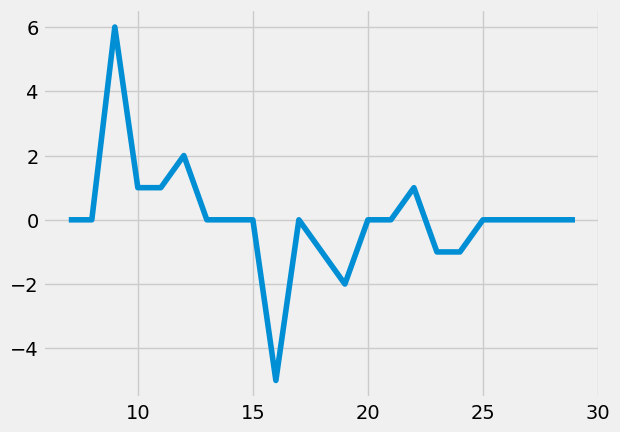

In [55]:
# Differencing to make it stationary
sample_ts = (train_dataset[train_dataset.columns[-30:]].loc[2]).reset_index()
sample_ts.columns = ['index', 'sales']

sample_ts['seasonal first difference'] = sample_ts['sales'] - sample_ts['sales'].shift(7)  

adfuller_test(sample_ts['seasonal first difference'].dropna())
sample_ts['seasonal first difference'].plot()
plt.show()

I use auto-correlation (ACF) and partial auto-correlation (PACF) to determine the number of previous days of data needed to make accurate predictions. The parameters p, d, and q correspond to:


- p: the number of lags in the AR (Auto-Regressive) model

- d: the degree of differencing

- q: the number of lags in the MA (Moving Average) model
The number of lags in the AR model is best estimated using PACF, while the number of lags in the MA model is best estimated using ACF.







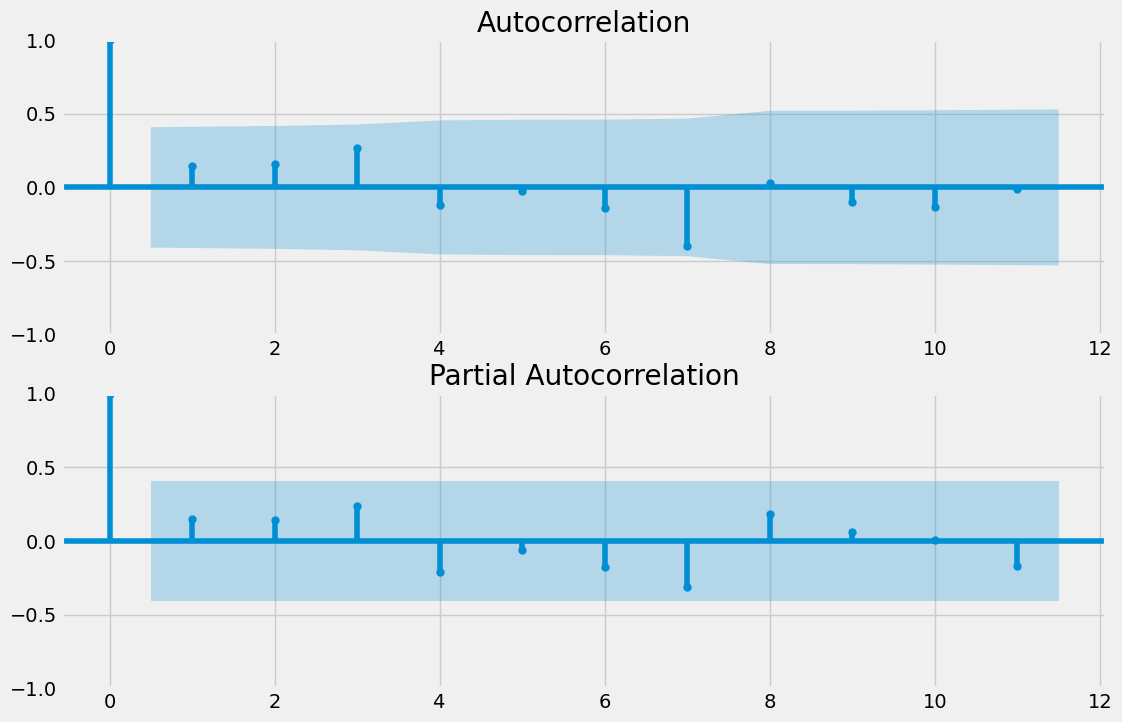

In [65]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sample_ts['seasonal first difference'].dropna(),ax=ax1)
ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sample_ts['seasonal first difference'].dropna(),ax=ax2)

AS we see we dont have significant lags here. But intesting that we have mostly significant lag = 7 for both plots. I assume that we have a weekly seasonality based on EDA plots and ACF, PACF plots.So we will use it in seasonal order in Sarima model.

## 3. Baseline modeling ##

#### SARIMA ####

So as I mentioned before we need to use seasonal model so I chose for seasonal order in sarima model next parameters:
- P=0: No seasonal autoregressive terms.
- D=1: One seasonal difference to make the series stationary at the seasonal frequency.
- Q=1: One seasonal moving average term.
- s=7: The seasonal cycle repeats every 7 periods (e.g., days in a week).



In [112]:
def sarima():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[-4:]):
        print(row)
        fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0,1,1,7)).fit()
        predictions.append(fit.forecast(30))
        print(f"***AIC {fit.aic}")
    predictions = np.array(predictions).reshape(-1, 30)
    return predictions


  0%|          | 0/4 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.65013D+00    |proj g|=  2.14796D+05
  ys=-2.019E+00  -gs= 6.257E-01 BFGS update SKIPPED


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 25%|██▌       | 1/4 [00:00<00:01,  1.94it/s] This problem is unconstrained.
 This problem is unconstrained.
 75%|███████▌  | 3/4 [00:00<00:00,  5.36it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     60      2     1     0   1.958D+04  -7.377D+00
  F =  -7.3769511620889698     

ABNORMAL_TERMINATION_IN_LNSRCH                              
***AIC -436.6170697253382
[0 0 2 0 1 2 2 2 2 2 2 1 1 2 1 3 1 1 0 3 1 1 2 0 0 2 0 0 0 2]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30915D+00    |proj g|=  1.90378D-01

At iterate    5    f=  1.25310D+00    |proj g|=  1.02206D-03

           * * *

Tit   = total number of i

100%|██████████| 4/4 [00:00<00:00,  5.09it/s]



At iterate    5    f=  1.64971D+00    |proj g|=  4.65828D-03

At iterate   10    f=  1.64885D+00    |proj g|=  1.82101D-03

At iterate   15    f=  1.64876D+00    |proj g|=  1.53820D-03

At iterate   20    f=  1.64875D+00    |proj g|=  7.06685D-04

At iterate   25    f=  1.64874D+00    |proj g|=  2.71772D-04

At iterate   30    f=  1.64874D+00    |proj g|=  1.30606D-04

At iterate   35    f=  1.64874D+00    |proj g|=  2.71382D-04

At iterate   40    f=  1.64874D+00    |proj g|=  3.83537D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     51      1     0     0   3.835D-05   1.649D+00
  F =   1.64873967911

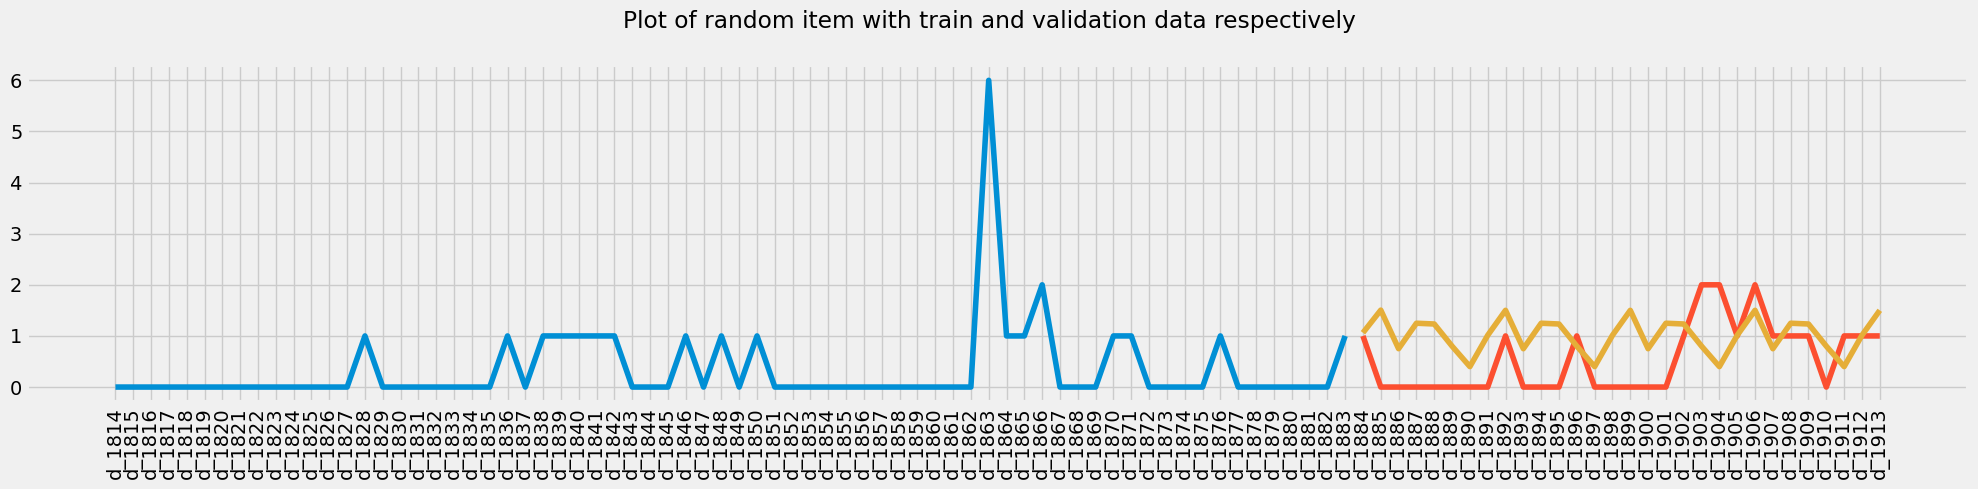

In [113]:
ids = [2]
pred= sarima()
plot_graphs(ids, pred, True)

I printed AIC that  stands for Akaike Information Criterion. It is a metric used in statistical modeling to compare the goodness of fit of different models. The AIC quantifies the trade-off between the goodness of fit of the model and the complexity of the model (number of parameters). Lower AIC Value indicates a better balance between model fit and complexity. A lower AIC suggests that the model is likely to be more predictive or informative with less complexity. It's quite logically that first out model has better (lower) AIC value 

In [96]:
def analyze_time_series(series):
    # Perform ADF test
    adf_result = adfuller(series)
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    for key, value in adf_result[4].items():
        print('Critical Values:')
        print(f'   {key}: {value}')

    # Perform KPSS test
    kpss_result = kpss(series, regression='ct')
    print('\nKPSS Statistic: %f' % kpss_result[0])
    print('p-value: %f' % kpss_result[1])
    for key, value in kpss_result[3].items():
        print('Critical Values:')
        print(f'   {key}: {value}')

    # Seasonal decomposition 
    result = seasonal_decompose(series, model='additive', period=7)
  

    # Plot decomposition
    result.plot()
    plt.show()

    # Plot distribution and diagnostics
    plt.figure(figsize=(12, 6))
    plt.subplot(231)
    sns.histplot(result.resid, kde=True)
    plt.title('Residuals Distribution')

    plt.subplot(232)
    stats.probplot(result.resid, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    plt.subplot(233)
    plt.plot(result.resid)
    plt.title('Residuals Over Time')

    plt.subplot(234)
    plot_acf(result.resid, ax=plt.gca())
    plt.title('ACF of Residuals')

    plt.subplot(235)
    plot_pacf(result.resid, ax=plt.gca())
    plt.title('PACF of Residuals')

    plt.tight_layout()
    plt.show()

ADF Statistic: -1.236741
p-value: 0.657594
Critical Values:
   1%: -4.068853732362312
Critical Values:
   5%: -3.1271488757396453
Critical Values:
   10%: -2.7017297633136095

KPSS Statistic: 0.141608
p-value: 0.058134
Critical Values:
   10%: 0.119
Critical Values:
   5%: 0.146
Critical Values:
   2.5%: 0.176
Critical Values:
   1%: 0.216


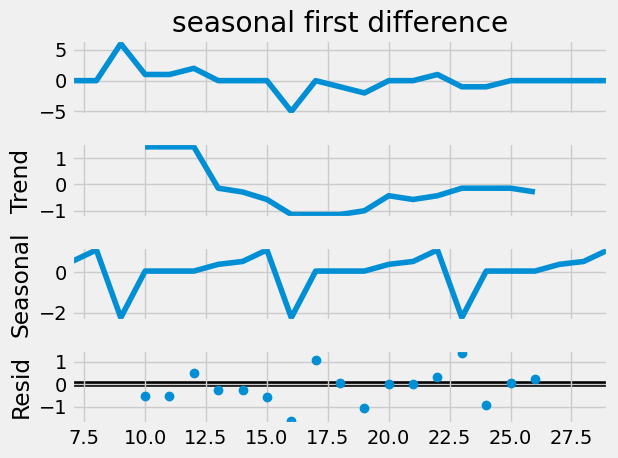

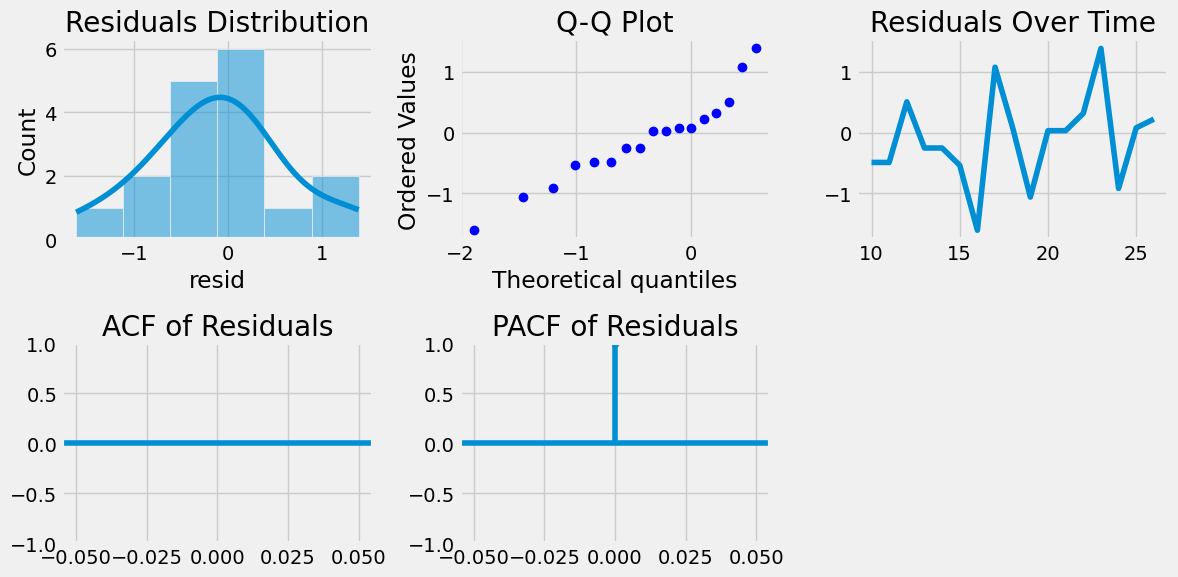

In [97]:
analyze_time_series(sample_ts['seasonal first difference'].dropna())

Based on the statistical results:


The ADF statistic is -1.236741, which is greater than the critical values at 1%, 5%, and 10% significance levels.
The p-value is 0.657594, which is much higher than the typical significance level of 0.05. So we fail to reject the null hypothesis. Therefore, the time series is likely non-stationary according to the ADF test.

The KPSS statistic is 0.141608, which is below the critical value at the 1% and 2.5% significance levels, and slightly above the critical value at the 10% level.
The p-value is 0.058134, which is close to the 0.05 significance level.

Depending on the significance level chosen, the results can be borderline. At a 5% significance level, we would not reject the null hypothesis, suggesting that the time series may be stationary.
However, the p-value being close to 0.05 suggests some caution and that the series might be borderline stationary.

The results from the ADF and KPSS tests are somewhat contradictory:

The ADF test suggests that the time series is non-stationary.
The KPSS test suggests that the time series may be stationary, particularly at a 5% significance level.
Given these mixed results, it is prudent to conclude that the time series is likely borderline non-stationary.


*Residuals Distribution*:

The residuals appear normally distributed.
Residuals range from -1 to 1, indicating steep peaks and valleys.

*Q-Q Plot* :

The Q-Q plot of the residuals almost forms a straight line, suggesting that the residuals are approximately normally distributed.

*Residuals Over Time:*

Residuals fluctuate between -1 and 1 with steep peaks and valleys.

*ACF and PACF of Residuals:*

If the residuals show no significant autocorrelation, it implies the model has captured the time series' patterns well.

#### Naive model #####

In [89]:
def naive_approach():
    predictions=[]
    for i in range(len(val_dataset.columns)):
        if i==0:
            predictions.append(train_dataset[train_dataset.columns[-1]].values)
        else:
            predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    predictions = np.transpose(np.array([list(row) for row in predictions]))
    return predictions

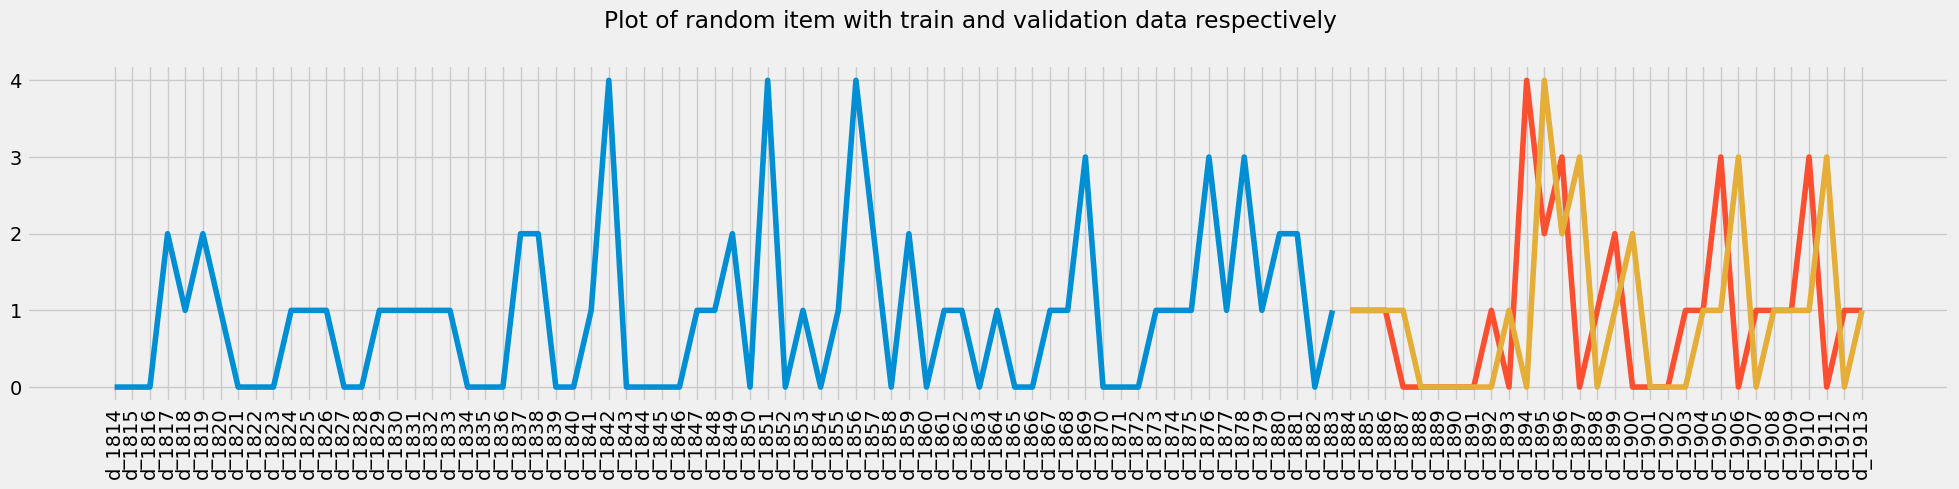

In [91]:
ids=[0]
pred =naive_approach()
plot_graphs(ids, pred, True)

As we see, this is a simple naive model without a seasonal component with a shift of 1. Our data isn't constatnt in nature and has steep peaks with sharp declines. so this is not the best model. 

#### Moving average ####

In [92]:
def moving_average(window=30):
    predictions = []
    for i in range(0, len(val_dataset.columns)):
        if i==0:
            predictions.append(np.mean(train_dataset[train_dataset.columns[-window:]].values, axis=1))
        if i>0 and i<=window:
            predictions.append(np.mean(train_dataset[train_dataset.columns[-window+i:]].values, axis=1) + np.mean(val_dataset[val_dataset.columns[:i]].values, axis=1))
        if i>(window+1):
            predictions.append(np.mean(val_dataset[val_dataset.columns[:i]].values, axis=1))
    predictions=np.transpose(np.array([list(row) for row in predictions]))
    
    return predictions

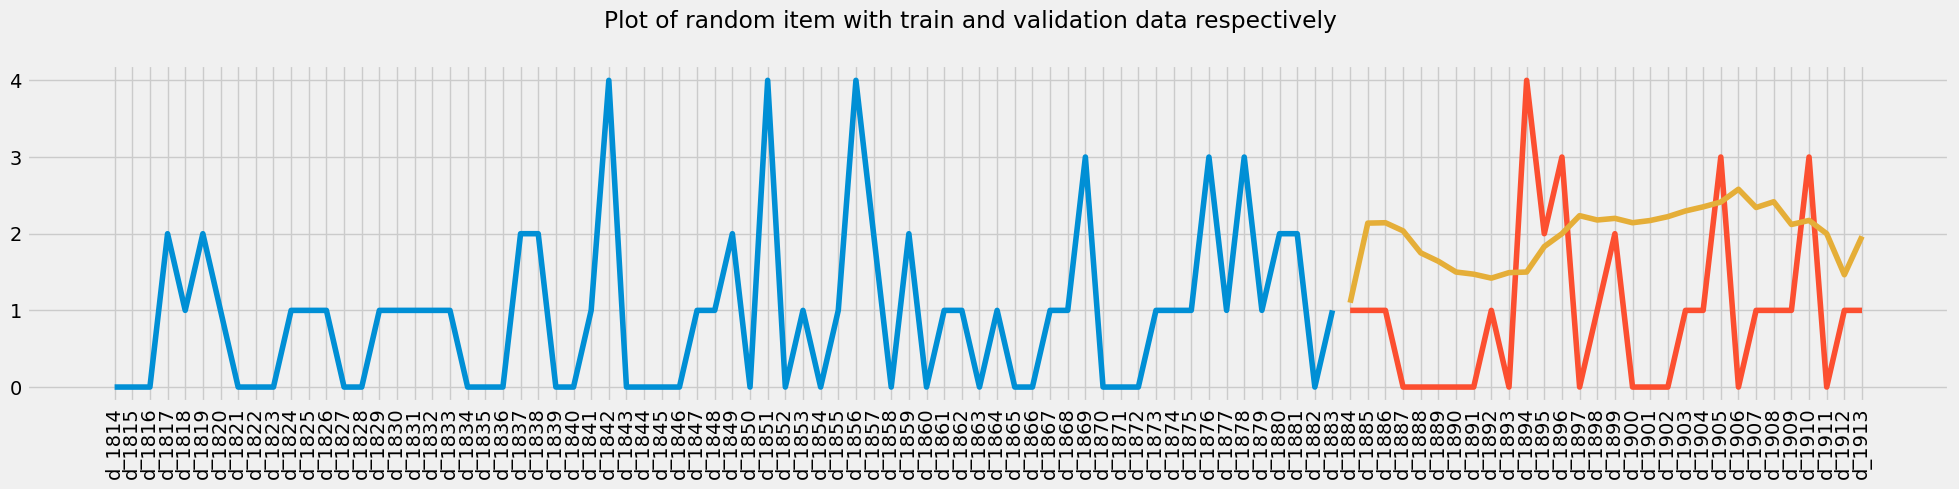

In [93]:
ids=[0]
pred = moving_average()
plot_graphs(ids, pred, True)

We see a classical model that smoothes tha data

#### Holt model ####

In [98]:
def holt_smoothing():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        fit = Holt(row).fit(smoothing_level=0.3, smoothing_slope=0.01)
        predictions.append(fit.forecast(30))
    predictions=np.array(predictions).reshape(-1,30)
    return predictions

100%|██████████| 3/3 [00:00<00:00, 728.68it/s]


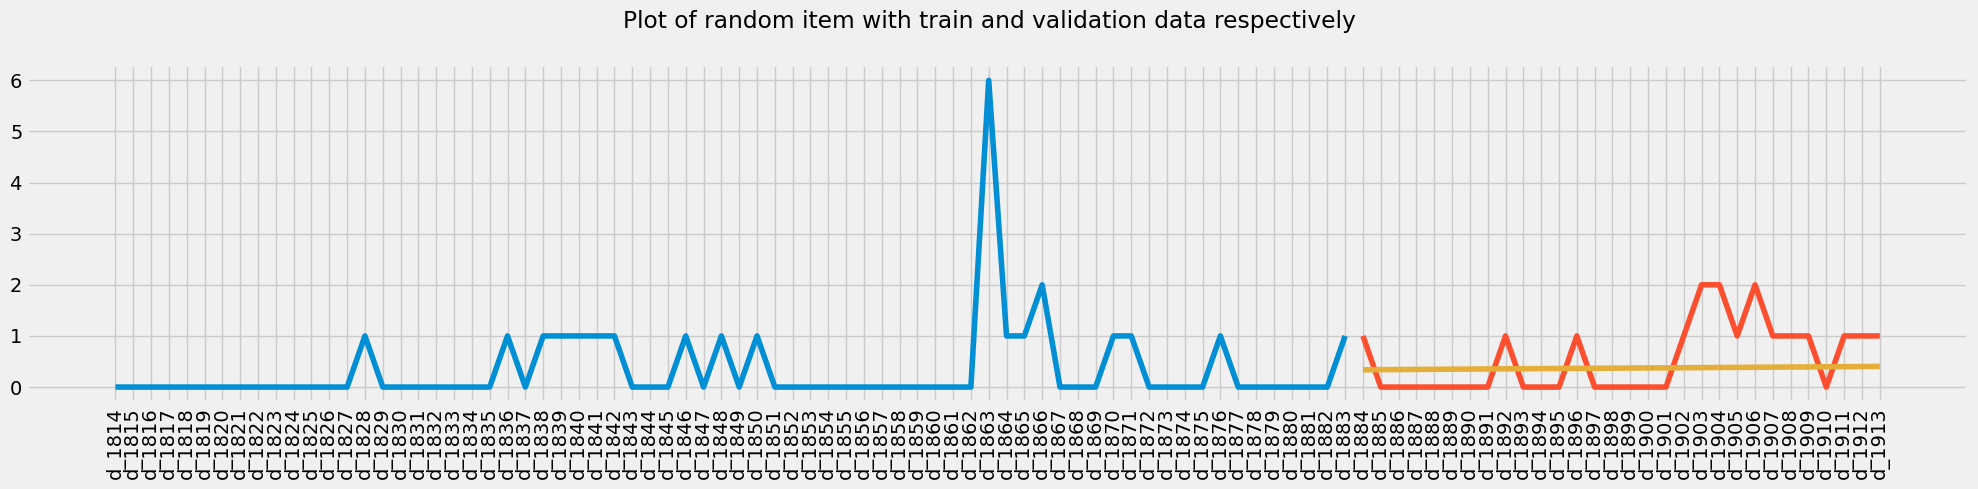

In [100]:
ids = [2]
pred= holt_smoothing()
plot_graphs(ids, pred, True)

I used Holt model that can capture average of typical value, trend.

#### Holt-Winter model ####

In [101]:
def winter_smoothing():
    predictions = []
    for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
        fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
        predictions.append(fit.forecast(30))
    predictions = np.array(predictions).reshape(-1, 30) # Reshaping to make sure it has 30 columns
    return predictions

100%|██████████| 3/3 [00:00<00:00, 229.50it/s]


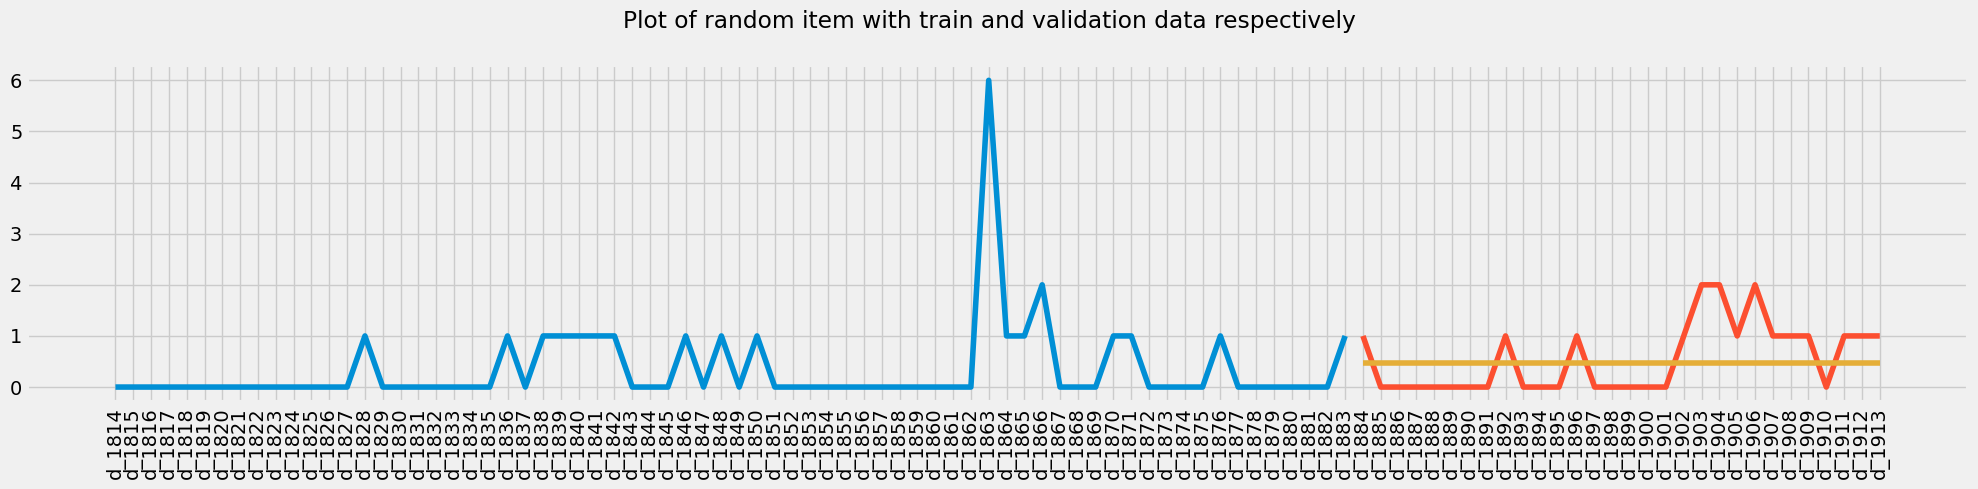

In [102]:
pred = winter_smoothing()
plot_graphs(ids, pred, True)

I used Holt-winter model that can capture average of typical value, trend and seasonal component 

#### Conclutions ####

Based on the analysis of Walmart sales data across states and stores from January 29th, 2011 to April 24th, 2016:

**Sales Trend**: There is an overall increasing trend in sales over the years.

**New Year's Day Effect**: Sales are observed to be zero on the very first day of each year due to store closures on New Year's Day.

**Yearly Seasonality**: Each year shows seasonal patterns, and the time series within each year is stationary.

**Monthly Sales**: March tends to have the highest monthly sales, while November has the lowest.

**Weekly Sales**: Sales are highest on weekends compared to weekdays (Monday to Thursday), with Fridays slightly higher than other weekdays.

**Sales by State**: California has the highest sales and revenue generated. Texas and Wisconsin show similar levels of sales and revenue.

**Category Analysis**: The Food category accounts for 70% of sales but contributes only 58% of the revenue, indicating lower average prices compared to other categories.

**SNAP Day Effect**: Sales are slightly higher on SNAP (Supplemental Nutrition Assistance Program) days compared to non-SNAP days across all states.

**Product Sales Patterns**: Each product category exhibits non-periodic daily sales patterns, with Food products showing higher overall sales and revenue due to their larger variety.

**Event Influence**: Sales increase during sporting and cultural events but decrease on national holidays.

**Month-end Effect**: Sales are higher at the beginning of the month and decrease gradually towards the end.

**SNAP Day Sales Impact**: SNAP days show an increase in sales, ranging from at least 4% to as high as 30% compared to non-SNAP days.

This analysis highlights the complex and varied sales patterns across different dimensions such as time, category, state, and event influence at Walmart stores.